In [1]:
import pandas as pd
import numpy as np
import itertools
import pickle
import torch
import matplotlib.pyplot as plt
%matplotlib inline
from statistics import mean, stdev
from scipy import stats, spatial
import antropy as ant
from ptflops import get_model_complexity_info

from main.layout import Layout
from main.models import Deeplab_ASPP_Layout
from main.auto_models import MTSeqBackbone, MTSeqModel
from main.algorithms import enum_layout, remove_redundancy, enum_layout_wo_rdt, metric_inference, init_S, coarse_to_fined

In [3]:
# Enum all layouts for given T (3 for NYUv2) and B (5 for coarse Deeplab_Resnet34)
data = 'NYUv2'
model = 'resnet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 5 
coarse = True

In [20]:
# Enum all layouts for given T (3 for NYUv2) and B (9 for coarse MobileNetv2)
data = 'NYUv2'
model = 'mobilenet'

T = 3 # segment_semantic, normal, depth_zbuffer
B = 5 # 9 - coarse v1/v4 with init weights, 6 - coarse v2, 5 - coase v3/v5 with init weights, 8 - shorter net
coarse = True

In [2]:
# Enum all layouts for given T (5 for Taskonomy) and B (5 for coarse Deeplab_Resnet34)
data = 'Taskonomy'
model = 'resnet'

T = 5 # segment_semantic, normal, depth_zbuffer, keypoints2d, edge_texture
B = 5 
coarse = True

In [23]:
# Enum all layouts for given T (5 for Taskonomy)  and B (5 for coarse MobileNetv2)
data = 'Taskonomy'
model = 'mobilenet'

T = 5 # segment_semantic, normal, depth_zbuffer, keypoints2d, edge_texture
B = 5 
coarse = True

In [3]:
layout_list = [] 
S0 = init_S(T, B) # initial state
L = Layout(T, B, S0) # initial layout
layout_list.append(L)

enum_layout_wo_rdt(L, layout_list)
len(layout_list)

7556

In [21]:
est_metric = 'val_acc'
real_metric = 'val_acc'
est_date = '0203'
real_date = '0123'

# Load 2-Task

In [24]:
two_task_pd = pd.read_excel('./2task/' + data + '_2task_metrics_' + model + '_' + est_date + '_' + est_metric +'.xlsx',engine='openpyxl',index_col=0)

In [25]:
two_task_pd

(0, 1)-0  (0, 1)-1  (1, 4)-0  (1, 4)-1  (0, 2)-0   (0, 2)-1  (0, 3)-0  \
branch                                                                          
0       0.000000  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000   
1       3.352925  0.187127  0.091344  0.763262  1.693018  -1.132075  0.968835   
2       3.222682  0.043518  0.200087  0.954077  0.980525  -7.924528  0.873984   
3       3.112477 -0.091388  0.156590  2.226180 -1.652304 -15.471698 -1.886856   
4       1.051964 -0.691936  0.187038  2.976721  1.455520 -22.893082 -0.203252   
5       1.392600 -1.040080  0.108743  4.337870  0.332496 -24.905660  1.060298   

        (0, 3)-1   (2, 4)-0  (2, 4)-1  (1, 3)-0  (1, 3)-1  (3, 4)-0  (3, 4)-1  \
branch                                                                          
0       0.000000   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1       0.649800 -75.449871  8.270194  0.160891  1.908186  1.354527  1.065879   
2      -0.096779 -11.311054  0.128419  0.191329  2.032633  1.948860 -0.064210   
3       4.009401 -12.982005  0.757673  0.160891  2.903761  1.271596 -0.115577   
4       6.000277 -14.267352  0.847566  0.100013  2.654867 -4.381479  0.179787   
5       7.258399 -17.737789 -2.529857  0.200026  5.129978 -3.413960 -0.333890   

        (1, 2)-0  (1, 2)-1  (0, 4)-0  (0, 4)-1   (2, 3)-0  (2, 3)-1  
branch                                                               
0       0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  
1       0.030447 -0.380228 -2.500601 -0.356143  -5.398458 -2.133932  
2      -0.178331 -0.887199 -1.882321  0.572373 -12.853470 -4.703075  
3      -0.030447 -2.534854 -1.033902  1.399135 -18.637532 -3.116664  
4      -0.047845 -4.816223 -2.339161  6.092597 -21.722365 -0.898498  
5      -0.017398 -7.604563 -2.631127  5.443907 -22.493573 -5.812158

In [26]:
tasks = [i for i in range(T)]
two_task_metrics = {}
for two_set in itertools.combinations(tasks, 2):
    two_task_metrics[two_set] = []
    for b in range(0, B+1): 
        metric1 = two_task_pd[str(two_set)+'-0'][b]
        metric2 = two_task_pd[str(two_set)+'-1'][b]
        two_task_metrics[two_set].append([metric1, metric2])

In [27]:
fluc = {}
for t in tasks:
    fluc[t] = []
    
for two_set in itertools.combinations(tasks, 2):
    print(two_set)
    for idx in range(2):
        metric = two_task_pd[str(two_set)+'-'+str(idx)].tolist()[1:]
        new_metric = [v for v in metric]
        print(metric)
        vol = ant.svd_entropy(new_metric, normalize=True)
        print(vol)
        fluc[two_set[idx]].append(vol)
        print('='*60)
        
score_weights = []
for key in fluc:
    score_weights.append(1-mean(fluc[key]))
score_weights_norm = [float(i)/sum(score_weights) for i in score_weights]
print(score_weights_norm)

(0, 1)
[3.35292546086027, 3.222682340368689, 3.112476623029658, 1.051963665508945, 1.392599519102327]
0.6594072821114396
[0.1871273771704539, 0.04351799469079985, -0.09138778885069418, -0.6919361155837901, -1.040080073110232]
0.6474080030281737
(0, 2)
[1.693017574811704, 0.9805252086584837, -1.652303725317227, 1.455520119427301, 0.3324964375381778]
0.8530783530506655
[-1.13207547169812, -7.924528301886798, -15.47169811320756, -22.8930817610063, -24.90566037735849]
0.3980383316410518
(0, 3)
[0.9688346883468896, 0.8739837398373924, -1.886856368563681, -0.2032520325203254, 1.060298102981026]
0.8769405986047728
[0.6497995299322639, -0.09677865339416647, 4.009401354901155, 6.000276510438276, 7.258399004562428]
0.7096947374163888
(0, 4)
[-2.500601106035092, -1.882320612784665, -1.033902380379888, -2.339161199464151, -2.631126987943527]
0.7499230779392533
[-0.3561434749427658, 0.5723734418722976, 1.399135080132297, 6.092597303485125, 5.443907402696519]
0.6215406317209506
(1, 2)
[0.03044669653

# Est. Results for Layouts

In [28]:
# Run for all L
for L in layout_list:
    print(L)
    metric_inference(L, two_task_metrics)
#     L.set_score()
    L.set_score_weighted(score_weights_norm)
    print(L.metric_list)
    print(L.score)
    print('=' * 100)

[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}]]
[[0, 1, 5], [0, 2, 5], [0, 3, 5], [0, 4, 5]]
[[1, 0, 5], [1, 2, 5], [1, 3, 5], [1, 4, 5]]
[[2, 0, 5], [2, 1, 5], [2, 3, 5], [2, 4, 5]]
[[3, 0, 5], [3, 1, 5], [3, 2, 5], [3, 4, 5]]
[[4, 0, 5], [4, 1, 5], [4, 2, 5], [4, 3, 5]]
[0.03856676791950092, -0.18717729083649612, -18.185396395716847, 0.7905647912296296, 1.7295076578850128]
-5.303393506863731
[[{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 5], [1, 3, 5], [1, 4, 5]]
[[2, 0, 0], [2, 1, 5], [2, 3, 5], [2, 4, 5]]
[[3, 0, 0], [3, 1, 5], [3, 2, 5], [3, 4, 5]]
[[4, 0, 0], [4, 1, 5], [4, 2, 5], [4, 3, 5]]
[0.0, 0.07284272744106188, -11.958981301377225, -1.0240349599109773, 0.3685308072108831]
-3.8575296930815925
[[{0}, {2, 3, 4}, {1}], [{0}, {2, 3, 4}, {1}], [{0}, {2, 3, 4}, {1}], [{0}, {2, 3, 4}, {1}], [{0}, {2, 3, 4}, {1}]]

[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 2], [3, 2, 0], [3, 4, 2]]
[[4, 0, 0], [4, 1, 3], [4, 2, 0], [4, 3, 2]]
[0.0, 0.0869797813709587, 0.0, 0.9953731132767852, 0.5404925738161492]
0.28890718137000865
[[{0}, {2}, {1, 3, 4}], [{0}, {2}, {1, 3, 4}], [{0}, {2}, {3}, {1, 4}], [{0}, {2}, {3}, {1, 4}], [{0}, {2}, {3}, {4}, {1}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 2], [1, 4, 4]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 2], [3, 2, 0], [3, 4, 2]]
[[4, 0, 0], [4, 1, 4], [4, 2, 0], [4, 3, 2]]
[0.0, 0.09459178659062223, 0.0, 0.9953731132767852, 0.7281277347371522]
0.3305719493018532
[[{0}, {2}, {1, 3, 4}], [{0}, {2}, {1, 3, 4}], [{0}, {2}, {4}, {1, 3}], [{0}, {2}, {4}, {1, 3}], [{0}, {2}, {4}, {1, 3}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 5], [1, 4, 2]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 5], [3, 2, 0], [3, 4, 2]]
[[4, 0, 0], [4, 1, 2], [4, 2, 0]

[[4, 0, 0], [4, 1, 1], [4, 2, 2], [4, 3, 2]]
[0.0, 0.07067032752769856, -8.353411790004596, 0.7396369316254218, 0.2068678129031055]
-2.4735124779934314
[[{1, 2, 3, 4}, {0}], [{0}, {2, 3, 4}, {1}], [{0}, {2, 3, 4}, {1}], [{0}, {1}, {3, 4}, {2}], [{0}, {1}, {3, 4}, {2}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 1], [1, 3, 1], [1, 4, 1]]
[[2, 0, 0], [2, 1, 1], [2, 3, 3], [2, 4, 3]]
[[3, 0, 0], [3, 1, 1], [3, 2, 3], [3, 4, 5]]
[[4, 0, 0], [4, 1, 1], [4, 2, 3], [4, 3, 5]]
[0.0, 0.07067032752769856, -7.9999413529866015, -1.1556096007976024, 0.2967612250001858]
-2.639049651972916
[[{1, 2, 3, 4}, {0}], [{0}, {2, 3, 4}, {1}], [{0}, {2, 3, 4}, {1}], [{0}, {1}, {2}, {4}, {3}], [{0}, {1}, {2}, {4}, {3}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 1], [1, 3, 1], [1, 4, 1]]
[[2, 0, 0], [2, 1, 1], [2, 3, 3], [2, 4, 3]]
[[3, 0, 0], [3, 1, 1], [3, 2, 3], [3, 4, 3]]
[[4, 0, 0], [4, 1, 1], [4, 2, 3], [4, 3, 3]]
[0.0, 0.07067032752769856, -7.9999413529866015, 0.

[[3, 0, 0], [3, 1, 4], [3, 2, 3], [3, 4, 1]]
[[4, 0, 0], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.0, 0.04022760282057995, -24.155564461213146, 0.2231823841453045, 2.5248336534065072]
-7.073292572240862
[[{1, 2, 3, 4}, {0}], [{0}, {4}, {1, 2, 3}], [{0}, {4}, {1, 2, 3}], [{0}, {4}, {3}, {1, 2}], [{0}, {4}, {3}, {1, 2}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 5], [1, 3, 3], [1, 4, 1]]
[[2, 0, 0], [2, 1, 5], [2, 3, 3], [2, 4, 1]]
[[3, 0, 0], [3, 1, 3], [3, 2, 3], [3, 4, 1]]
[[4, 0, 0], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.0, 0.05870912531813962, -25.42299158415358, 0.28540583547273707, 2.5248336534065072]
-7.461581386543131
[[{1, 2, 3, 4}, {0}], [{0}, {4}, {1, 2, 3}], [{0}, {4}, {1, 2, 3}], [{0}, {4}, {3}, {1, 2}], [{0}, {4}, {3}, {2}, {1}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 4], [1, 3, 3], [1, 4, 1]]
[[2, 0, 0], [2, 1, 4], [2, 3, 3], [2, 4, 1]]
[[3, 0, 0], [3, 1, 3], [3, 2, 3], [3, 4, 1]]
[[4, 0, 0], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.0, 0.

[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 3], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[-0.258475595094972, 0.0, 0.0, 0.0, 0.34978377003307426]
0.04574861947932502
[[{0, 4}, {1}, {3}, {2}], [{0, 4}, {1}, {3}, {2}], [{0, 4}, {1}, {3}, {2}], [{0, 4}, {1}, {3}, {2}], [{1}, {3}, {2}, {4}, {0}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 4]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 4], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[-0.5847902998660377, 0.0, 0.0, 0.0, 1.5231493258712812]
0.2600607016521505
[[{0, 4}, {2, 3}, {1}], [{2, 3}, {1}, {4}, {0}], [{2, 3}, {1}, {4}, {0}], [{2, 3}, {1}, {4}, {0}], [{2, 3}, {1}, {4}, {0}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 1]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 5], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 5], [3, 4, 0]]
[[4, 0, 1]

[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 5]]
[[1, 0, 0], [1, 2, 3], [1, 3, 3], [1, 4, 0]]
[[2, 0, 0], [2, 1, 3], [2, 3, 4], [2, 4, 0]]
[[3, 0, 0], [3, 1, 3], [3, 2, 4], [3, 4, 0]]
[[4, 0, 5], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[-0.6577817469858818, 0.032610963602003905, -6.064304821110319, 0.5013158094990791, 1.3609768506741298]
-1.619985276503548
[[{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{0, 4}, {2}, {1, 3}], [{0, 4}, {2}, {1, 3}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 5]]
[[1, 0, 0], [1, 2, 3], [1, 3, 5], [1, 4, 0]]
[[2, 0, 0], [2, 1, 3], [2, 3, 3], [2, 4, 0]]
[[3, 0, 0], [3, 1, 5], [3, 2, 3], [3, 4, 0]]
[[4, 0, 5], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[-0.6577817469858818, 0.04239484845654908, -5.29309659488924, 0.5033283873194034, 1.3609768506741298]
-1.3732681784350789
[[{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{2}, {1, 3}, {4}, {0}], [{2}, {1, 3}, {4}, {0}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 0], [0, 4, 3]]
[[1, 0, 0], [1, 2, 3], [1, 3, 5], [1

[[0, 1, 0], [0, 2, 0], [0, 3, 2], [0, 4, 0]]
[[1, 0, 0], [1, 2, 1], [1, 3, 0], [1, 4, 1]]
[[2, 0, 0], [2, 1, 1], [2, 3, 0], [2, 4, 5]]
[[3, 0, 2], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 1], [4, 2, 5], [4, 3, 0]]
[0.2184959349593481, 0.030447689792338965, -4.529504334991739, -0.024194663348541617, -0.4416489457972959]
-1.503292185065703
[[{1, 2, 4}, {0, 3}], [{0, 3}, {2, 4}, {1}], [{1}, {3}, {0}, {4}, {2}], [{1}, {3}, {0}, {4}, {2}], [{1}, {3}, {0}, {4}, {2}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 2], [0, 4, 0]]
[[1, 0, 0], [1, 2, 1], [1, 3, 0], [1, 4, 1]]
[[2, 0, 0], [2, 1, 1], [2, 3, 0], [2, 4, 2]]
[[3, 0, 2], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 1], [4, 2, 2], [4, 3, 0]]
[0.2184959349593481, 0.030447689792338965, -2.922820530364492, -0.024194663348541617, 0.22292020792044032]
-0.8518531503059995
[[{1, 2, 4}, {0, 3}], [{0, 3}, {2, 4}, {1}], [{2, 4}, {1}, {3}, {0}], [{1}, {3}, {0}, {4}, {2}], [{1}, {3}, {0}, {4}, {2}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 2], [0, 4, 0]]
[[

[[4, 0, 0], [4, 1, 3], [4, 2, 4], [4, 3, 0]]
[-0.47171409214092025, 0.031535781282041604, -4.200551607742708, 1.0023503387252888, 0.768436583062325]
-1.0568235526215062
[[{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{0, 3}, {1}, {4}, {2}], [{0, 3}, {1}, {4}, {2}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 5], [0, 4, 0]]
[[1, 0, 0], [1, 2, 3], [1, 3, 0], [1, 4, 3]]
[[2, 0, 0], [2, 1, 3], [2, 3, 0], [2, 4, 3]]
[[3, 0, 5], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 3], [4, 2, 3], [4, 3, 0]]
[0.2650745257452565, 0.031535781282041604, -3.87921484681726, 1.814599751140607, 0.7459632300380563]
-0.7496719425292658
[[{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{0, 3}, {1}, {4}, {2}], [{1}, {4}, {2}, {3}, {0}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 4], [0, 4, 0]]
[[1, 0, 0], [1, 2, 3], [1, 3, 0], [1, 4, 3]]
[[2, 0, 0], [2, 1, 3], [2, 3, 0], [2, 4, 3]]
[[3, 0, 4], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 3], [4, 2, 3], [4, 3, 0]]
[-0.05081300813008135, 0.03153

[[{1, 2}, {0, 3, 4}], [{1, 2}, {3, 4}, {0}], [{1, 2}, {3, 4}, {0}], [{0}, {2}, {1}, {4}, {3}], [{0}, {2}, {1}, {4}, {3}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 1], [0, 4, 1]]
[[1, 0, 0], [1, 2, 3], [1, 3, 0], [1, 4, 0]]
[[2, 0, 0], [2, 1, 3], [2, 3, 0], [2, 4, 0]]
[[3, 0, 1], [3, 1, 0], [3, 2, 0], [3, 4, 3]]
[[4, 0, 1], [4, 1, 0], [4, 2, 0], [4, 3, 3]]
[-0.3829416044220506, -0.0076116741333556925, -0.633713561470215, 0.480348984072561, -0.11793017976689948]
-0.19548026781711952
[[{1, 2}, {0, 3, 4}], [{1, 2}, {3, 4}, {0}], [{1, 2}, {3, 4}, {0}], [{3, 4}, {0}, {2}, {1}], [{0}, {2}, {1}, {4}, {3}]]
[[0, 1, 0], [0, 2, 0], [0, 3, 1], [0, 4, 1]]
[[1, 0, 0], [1, 2, 3], [1, 3, 0], [1, 4, 0]]
[[2, 0, 0], [2, 1, 3], [2, 3, 0], [2, 4, 0]]
[[3, 0, 1], [3, 1, 0], [3, 2, 0], [3, 4, 4]]
[[4, 0, 1], [4, 1, 0], [4, 2, 0], [4, 3, 4]]
[-0.3829416044220506, -0.0076116741333556925, -0.633713561470215, -0.9329198479937801, -0.0440891626871486]
-0.4010087186976326
[[{1, 2}, {0, 3, 4}], [{1, 2}, {3, 4}, {0}], [{1, 2}

[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 1]]
[0.24513130216462092, 0.0, -1.9811320754716994, 0.3386316516931585, 0.26646975728779]
-0.49032547216319067
[[{0, 2}, {3, 4}, {1}], [{0, 2}, {1}, {4}, {3}], [{0, 2}, {1}, {4}, {3}], [{1}, {4}, {3}, {2}, {0}], [{1}, {4}, {3}, {2}, {0}]]
[[0, 1, 0], [0, 2, 3], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 3], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 1]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 1]]
[-0.41307593132930676, 0.0, -3.86792452830189, 0.3386316516931585, 0.26646975728779]
-1.1624335485906039
[[{0, 2}, {3, 4}, {1}], [{0, 2}, {1}, {4}, {3}], [{0, 2}, {1}, {4}, {3}], [{0, 2}, {1}, {4}, {3}], [{1}, {4}, {3}, {2}, {0}]]
[[0, 1, 0], [0, 2, 4], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 4], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 1]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 1]]
[0.36388002985682527, 0.0, -5.723270440

[[1, 0, 0], [1, 2, 0], [1, 3, 4], [1, 4, 4]]
[[2, 0, 1], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 4], [3, 2, 0], [3, 4, 4]]
[[4, 0, 0], [4, 1, 4], [4, 2, 0], [4, 3, 4]]
[0.423254393702926, 0.0717627219300132, -0.28301886792453, -0.4316529163175524, 0.7891268358030299]
0.0734947936776281
[[{1, 3, 4}, {0, 2}], [{1, 3, 4}, {2}, {0}], [{1, 3, 4}, {2}, {0}], [{1, 3, 4}, {2}, {0}], [{2}, {0}, {3}, {1, 4}]]
[[0, 1, 0], [0, 2, 1], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 4], [1, 4, 5]]
[[2, 0, 1], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 4], [3, 2, 0], [3, 4, 4]]
[[4, 0, 0], [4, 1, 5], [4, 2, 0], [4, 3, 4]]
[0.423254393702926, 0.052188994222312726, -0.28301886792453, -0.4316529163175524, 1.129414331032639]
0.14238164286472704
[[{1, 3, 4}, {0, 2}], [{1, 3, 4}, {2}, {0}], [{1, 3, 4}, {2}, {0}], [{1, 3, 4}, {2}, {0}], [{2}, {0}, {4}, {1, 3}]]
[[0, 1, 0], [0, 2, 1], [0, 3, 0], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 5], [1, 4, 4]]
[[2, 0, 1], [2, 1, 0], [2, 3, 0],

[-0.6715515264242787, 0.0402226377353596, -7.113425813648935, 0.47704646017699326, 0.5392020312376464]
-2.1321573672649756
[[{1, 3}, {0, 2, 4}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{3}, {1}, {2, 4}, {0}], [{3}, {1}, {0}, {4}, {2}]]
[[0, 1, 0], [0, 2, 3], [0, 3, 0], [0, 4, 3]]
[[1, 0, 0], [1, 2, 0], [1, 3, 1], [1, 4, 0]]
[[2, 0, 3], [2, 1, 0], [2, 3, 0], [2, 4, 4]]
[[3, 0, 0], [3, 1, 1], [3, 2, 0], [3, 4, 0]]
[[4, 0, 3], [4, 1, 0], [4, 2, 4], [4, 3, 0]]
[-0.6715515264242787, 0.0402226377353596, -7.434762574574383, 0.47704646017699326, 0.5616753842619153]
-2.229201693377
[[{1, 3}, {0, 2, 4}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{3}, {1}, {2}, {0, 4}], [{3}, {1}, {2}, {0, 4}]]
[[0, 1, 0], [0, 2, 3], [0, 3, 0], [0, 4, 5]]
[[1, 0, 0], [1, 2, 0], [1, 3, 1], [1, 4, 0]]
[[2, 0, 3], [2, 1, 0], [2, 3, 0], [2, 4, 3]]
[[3, 0, 0], [3, 1, 1], [3, 2, 0], [3, 4, 0]]
[[4, 0, 5], [4, 1, 0], [4, 2, 3], [4, 3, 0]]
[-1.0708576783151886, 0.0402226377353596, -7.113425813648935, 0.477046

[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[0.463627237123969, 0.0, -6.640515108890725, -0.8033607450556893, 0.0]
-2.178448894979094
[[{0, 2, 3}, {4}, {1}], [{0, 2, 3}, {4}, {1}], [{4}, {1}, {2, 3}, {0}], [{4}, {1}, {2, 3}, {0}], [{4}, {1}, {0}, {3}, {2}]]
[[0, 1, 0], [0, 2, 2], [0, 3, 2], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 2], [2, 1, 0], [2, 3, 4], [2, 4, 0]]
[[3, 0, 2], [3, 1, 0], [3, 2, 4], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[0.463627237123969, 0.0, -7.411723335111804, -0.24881911933618883, 0.0]
-2.3360499505621535
[[{0, 2, 3}, {4}, {1}], [{0, 2, 3}, {4}, {1}], [{4}, {1}, {2}, {0, 3}], [{4}, {1}, {2}, {0, 3}], [{4}, {1}, {2}, {0, 3}]]
[[0, 1, 0], [0, 2, 2], [0, 3, 5], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 2], [2, 1, 0], [2, 3, 2], [2, 4, 0]]
[[3, 0, 5], [3, 1, 0], [3, 2, 2], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[0.5102058279098773, 0.0, -5.1944996847262, 0.638831114330275, 0.0]
-1.489017

[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 3]]
[[2, 0, 2], [2, 1, 0], [2, 3, 3], [2, 4, 0]]
[[3, 0, 2], [3, 1, 0], [3, 2, 3], [3, 4, 0]]
[[4, 0, 0], [4, 1, 3], [4, 2, 0], [4, 3, 0]]
[0.463627237123969, 0.0391474554153973, -6.640515108890725, -0.8033607450556893, 0.556544968833484]
-2.0515535732565273
[[{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {2, 3}, {0}], [{2, 3}, {0}, {4}, {1}], [{0}, {4}, {1}, {3}, {2}]]
[[0, 1, 0], [0, 2, 2], [0, 3, 2], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 3]]
[[2, 0, 2], [2, 1, 0], [2, 3, 4], [2, 4, 0]]
[[3, 0, 2], [3, 1, 0], [3, 2, 4], [3, 4, 0]]
[[4, 0, 0], [4, 1, 3], [4, 2, 0], [4, 3, 0]]
[0.463627237123969, 0.0391474554153973, -7.411723335111804, -0.24881911933618883, 0.556544968833484]
-2.209154628839587
[[{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {2, 3}, {0}], [{1, 4}, {0}, {3}, {2}], [{1, 4}, {0}, {3}, {2}]]
[[0, 1, 0], [0, 2, 2], [0, 3, 2], [0, 4, 0]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 5]]
[[2, 0, 2], [2, 1, 0], [2, 3, 3

[[{1}, {0, 2, 3, 4}], [{1}, {0, 3}, {4}, {2}], [{1}, {0, 3}, {4}, {2}], [{1}, {4}, {2}, {3}, {0}], [{1}, {4}, {2}, {3}, {0}]]
[[0, 1, 0], [0, 2, 1], [0, 3, 3], [0, 4, 1]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 1], [2, 1, 0], [2, 3, 1], [2, 4, 1]]
[[3, 0, 3], [3, 1, 0], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 0], [4, 2, 1], [4, 3, 1]]
[-0.6736099749467672, 0.0, -20.49510113013533, 0.807498907447789, 2.2449823667850506]
-5.9652602393730065
[[{1}, {0, 2, 3, 4}], [{1}, {0, 3}, {4}, {2}], [{1}, {0, 3}, {4}, {2}], [{1}, {0, 3}, {4}, {2}], [{1}, {4}, {2}, {3}, {0}]]
[[0, 1, 0], [0, 2, 1], [0, 3, 4], [0, 4, 1]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 1], [2, 1, 0], [2, 3, 1], [2, 4, 1]]
[[3, 0, 4], [3, 1, 0], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 0], [4, 2, 1], [4, 3, 1]]
[-0.2527088909359283, 0.0, -20.49510113013533, 1.3052176963320692, 2.2449823667850506]
-5.839954312136796
[[{1}, {0, 2, 3, 4}], [{1}, {2, 4}, {0, 3}], [{1}, {0, 3}, {4}, {2}], [{1}, {0, 3}, {4},

[[{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {2, 3}, {0, 4}], [{1}, {3}, {2}, {4}, {0}], [{1}, {3}, {2}, {4}, {0}]]
[[0, 1, 0], [0, 2, 2], [0, 3, 2], [0, 4, 3]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 2], [2, 1, 0], [2, 3, 3], [2, 4, 2]]
[[3, 0, 2], [3, 1, 0], [3, 2, 3], [3, 4, 2]]
[[4, 0, 3], [4, 1, 0], [4, 2, 2], [4, 3, 2]]
[0.20515164202899705, 0.0, -9.468278605034685, -0.3161458176196136, 0.3658361650504144]
-2.9492653451240733
[[{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {2, 3}, {0, 4}], [{1}, {0, 4}, {3}, {2}], [{1}, {3}, {2}, {4}, {0}]]
[[0, 1, 0], [0, 2, 2], [0, 3, 2], [0, 4, 4]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 2], [2, 1, 0], [2, 3, 3], [2, 4, 2]]
[[3, 0, 2], [3, 1, 0], [3, 2, 3], [3, 4, 2]]
[[4, 0, 4], [4, 1, 0], [4, 2, 2], [4, 3, 2]]
[-0.12116306274206867, 0.0, -9.468278605034685, -0.3161458176196136, 1.5392017208886213]
-2.734953262951248
[[{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {2, 3}, {0, 4}], [{1}, {2, 3}, {4}, {0}], [{1},

[-0.27172327813929376, 0.0, -14.91350180271944, -1.0483400525373576, 1.779987646148665]
-4.540987753307858
[[{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {2, 3}, {0, 4}]]
[[0, 1, 0], [0, 2, 4], [0, 3, 4], [0, 4, 5]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 4], [2, 1, 0], [2, 3, 5], [2, 4, 4]]
[[3, 0, 4], [3, 1, 0], [3, 2, 5], [3, 4, 4]]
[[4, 0, 5], [4, 1, 0], [4, 2, 4], [4, 3, 4]]
[-0.3447147252591378, 0.0, -14.91350180271944, -1.0483400525373576, 1.6178151709515136]
-4.583895966884966
[[{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 4}, {3}, {2}]]
[[0, 1, 0], [0, 2, 4], [0, 3, 4], [0, 4, 5]]
[[1, 0, 0], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 4], [2, 1, 0], [2, 3, 4], [2, 4, 4]]
[[3, 0, 4], [3, 1, 0], [3, 2, 4], [3, 4, 4]]
[[4, 0, 5], [4, 1, 0], [4, 2, 4], [4, 3, 4]]
[-0.3447147252591378, 0.0, -14.720699746164172, 0.18007494114507563, 1.6178151709515136]
-4.330407800700763
[[{1}, {0,

[[3, 0, 0], [3, 1, 0], [3, 2, 1], [3, 4, 1]]
[[4, 0, 0], [4, 1, 0], [4, 2, 3], [4, 3, 1]]
[0.26299091637723626, -0.17298402889594752, -4.595115681233937, -0.19485143127749976, 0.4558880184923622]
-1.394469139209209
[[{2, 3, 4}, {0, 1}], [{0, 1}, {3}, {2, 4}], [{0, 1}, {3}, {2, 4}], [{0, 1}, {3}, {2, 4}], [{3}, {2, 4}, {1}, {0}]]
[[0, 1, 4], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 4], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 1], [2, 4, 5]]
[[3, 0, 0], [3, 1, 0], [3, 2, 1], [3, 4, 1]]
[[4, 0, 0], [4, 1, 0], [4, 2, 5], [4, 3, 1]]
[0.26299091637723626, -0.17298402889594752, -5.784061696658099, -0.19485143127749976, -0.36599460639527126]
-1.94715581625288
[[{2, 3, 4}, {0, 1}], [{0, 1}, {3}, {2, 4}], [{0, 1}, {3}, {2, 4}], [{0, 1}, {3}, {2, 4}], [{3}, {1}, {0}, {4}, {2}]]
[[0, 1, 4], [0, 2, 0], [0, 3, 0], [0, 4, 0]]
[[1, 0, 4], [1, 2, 0], [1, 3, 0], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 1], [2, 4, 4]]
[[3, 0, 0], [3, 1, 0], [3, 2, 1], [3, 4, 1]]
[[4, 0, 0], [4, 1, 0

[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 2], [4, 1, 3], [4, 2, 0], [4, 3, 0]]
[0.335090431896006, 0.050026954088097264, 0.0, 0.0, 0.6996383293015584]
0.19738902848879814
[[{0, 1, 4}, {3}, {2}], [{0, 1, 4}, {3}, {2}], [{3}, {2}, {1, 4}, {0}], [{3}, {2}, {1, 4}, {0}], [{3}, {2}, {0}, {4}, {1}]]
[[0, 1, 2], [0, 2, 0], [0, 3, 0], [0, 4, 2]]
[[1, 0, 2], [1, 2, 0], [1, 3, 0], [1, 4, 4]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 2], [4, 1, 4], [4, 2, 0], [4, 3, 0]]
[0.335090431896006, 0.05763895930776079, 0.0, 0.0, 0.8872734902225614]
0.23905379642064273
[[{0, 1, 4}, {3}, {2}], [{0, 1, 4}, {3}, {2}], [{3}, {2}, {1}, {0, 4}], [{3}, {2}, {1}, {0, 4}], [{3}, {2}, {1}, {0, 4}]]
[[0, 1, 2], [0, 2, 0], [0, 3, 0], [0, 4, 5]]
[[1, 0, 2], [1, 2, 0], [1, 3, 0], [1, 4, 2]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 5], [4, 1, 2], [4, 2, 0], [4, 3, 0]]
[0.1478888381062905, 0.06090124

[-0.23664042009045594, -0.21326055764249718, -5.623393316195372, -1.4530394496700805, 2.2673294556257684]
-1.594169877174152
[[{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}]]
[[0, 1, 5], [0, 2, 0], [0, 3, 5], [0, 4, 0]]
[[1, 0, 5], [1, 2, 0], [1, 3, 5], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 5]]
[[3, 0, 5], [3, 1, 5], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 5], [4, 3, 0]]
[0.6132244055208382, -0.2100134956876532, -4.4344473007712075, 3.097094220167158, -0.6324643636830612]
-1.0288432809619388
[[{0, 1, 3}, {4}, {2}], [{0, 1, 3}, {4}, {2}], [{0, 1, 3}, {4}, {2}], [{0, 1, 3}, {4}, {2}], [{0, 1, 3}, {4}, {2}]]
[[0, 1, 5], [0, 2, 0], [0, 3, 5], [0, 4, 0]]
[[1, 0, 5], [1, 2, 0], [1, 3, 5], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 5], [3, 1, 5], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[0.6132244055208382, -0.2100134956876532, 0.0, 3.097094220167158, 0.0]
0.5120272

[[3, 0, 3], [3, 1, 3], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 2], [4, 3, 0]]
[0.3064050636164943, 0.017375690522686053, -2.82776349614396, 1.728290604212015, 0.03210479003467497]
-0.5808195986774363
[[{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{0, 1, 3}, {4}, {2}], [{4}, {2}, {1, 3}, {0}], [{4}, {2}, {0}, {3}, {1}]]
[[0, 1, 3], [0, 2, 0], [0, 3, 3], [0, 4, 0]]
[[1, 0, 3], [1, 2, 0], [1, 3, 4], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 2]]
[[3, 0, 3], [3, 1, 4], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 2], [4, 3, 0]]
[0.3064050636164943, 0.002156314082278829, -2.82776349614396, 1.6660671528845825, 0.03210479003467497]
-0.5936075517903674
[[{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{0, 1, 3}, {4}, {2}], [{4}, {2}, {1}, {0, 3}], [{4}, {2}, {1}, {0, 3}]]
[[0, 1, 3], [0, 2, 0], [0, 3, 5], [0, 4, 0]]
[[1, 0, 3], [1, 2, 0], [1, 3, 3], [1, 4, 0]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 2]]
[[3, 0, 5], [3, 1, 3], [3, 2, 0], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4,

[[1, 0, 2], [1, 2, 0], [1, 3, 1], [1, 4, 1]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 1], [3, 1, 1], [3, 2, 0], [3, 4, 5]]
[[4, 0, 1], [4, 1, 1], [4, 2, 0], [4, 3, 5]]
[0.42272898067012166, 0.07393815206704284, 0.0, -0.21399363660738874, 0.018307095059922132]
0.032755332937760076
[[{2}, {0, 1, 3, 4}], [{2}, {3, 4}, {0, 1}], [{2}, {3, 4}, {1}, {0}], [{2}, {1}, {0}, {4}, {3}], [{2}, {1}, {0}, {4}, {3}]]
[[0, 1, 2], [0, 2, 0], [0, 3, 1], [0, 4, 1]]
[[1, 0, 2], [1, 2, 0], [1, 3, 1], [1, 4, 1]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 1], [3, 1, 1], [3, 2, 0], [3, 4, 3]]
[[4, 0, 1], [4, 1, 1], [4, 2, 0], [4, 3, 3]]
[0.42272898067012166, 0.07393815206704284, 0.0, 0.9573954442495543, 0.07288523811886585]
0.22787798408528132
[[{2}, {0, 1, 3, 4}], [{2}, {3, 4}, {0, 1}], [{2}, {3, 4}, {1}, {0}], [{2}, {3, 4}, {1}, {0}], [{2}, {1}, {0}, {4}, {3}]]
[[0, 1, 2], [0, 2, 0], [0, 3, 1], [0, 4, 1]]
[[1, 0, 2], [1, 2, 0], [1, 3, 1], [1, 4, 1]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2,

[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 4}, {3}, {1}], [{2}, {3}, {1}, {4}, {0}], [{2}, {3}, {1}, {4}, {0}]]
[[0, 1, 2], [0, 2, 0], [0, 3, 2], [0, 4, 3]]
[[1, 0, 2], [1, 2, 0], [1, 3, 2], [1, 4, 2]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 2], [3, 1, 2], [3, 2, 0], [3, 4, 2]]
[[4, 0, 3], [4, 1, 2], [4, 2, 0], [4, 3, 2]]
[0.7656909249565484, 0.10873357321460499, 0.0, 0.9711784499282436, 0.5722506473729462]
0.38241906654988106
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 4}, {3}, {1}], [{2}, {0, 4}, {3}, {1}], [{2}, {3}, {1}, {4}, {0}]]
[[0, 1, 2], [0, 2, 0], [0, 3, 2], [0, 4, 4]]
[[1, 0, 2], [1, 2, 0], [1, 3, 2], [1, 4, 2]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 2], [3, 1, 2], [3, 2, 0], [3, 4, 2]]
[[4, 0, 4], [4, 1, 2], [4, 2, 0], [4, 3, 2]]
[0.43937622018548267, 0.10873357321460499, 0.0, 0.9711784499282436, 1.745616203211153]
0.5967311487227065
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {1, 3}, {0, 4}], [{2}, {0, 4}, {3}, {1}], [{2}

[[3, 0, 4], [3, 1, 4], [3, 2, 0], [3, 4, 4]]
[[4, 0, 4], [4, 1, 4], [4, 2, 0], [4, 3, 4]]
[-0.37261239161888277, -0.10122130696593432, 0.0, 1.0684162112920166, 2.312276161674311]
0.599839700242094
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0}, {3}, {1, 4}]]
[[0, 1, 4], [0, 2, 0], [0, 3, 4], [0, 4, 4]]
[[1, 0, 4], [1, 2, 0], [1, 3, 4], [1, 4, 5]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 4], [3, 1, 4], [3, 2, 0], [3, 4, 4]]
[[4, 0, 4], [4, 1, 5], [4, 2, 0], [4, 3, 4]]
[-0.37261239161888277, -0.1207950346736348, 0.0, 1.0684162112920166, 2.65256365690392]
0.6687265494291929
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0}, {4}, {1, 3}]]
[[0, 1, 4], [0, 2, 0], [0, 3, 4], [0, 4, 4]]
[[1, 0, 4], [1, 2, 0], [1, 3, 5], [1, 4, 4]]
[[2, 0, 0], [2, 1, 0], [2, 3, 0], [2, 4, 0]]
[[3, 0, 4], [3, 1, 5], [3, 2, 0], [3, 4, 4]]
[[4, 0, 4], [4, 1, 4], [4, 2, 0], [4, 3, 4]]
[-0.37261239161888277, -0.0

[[{3, 4}, {0, 1, 2}], [{3, 4}, {0, 1, 2}], [{3, 4}, {2}, {0, 1}], [{3, 4}, {2}, {1}, {0}], [{2}, {1}, {0}, {4}, {3}]]
[[0, 1, 3], [0, 2, 2], [0, 3, 0], [0, 4, 0]]
[[1, 0, 3], [1, 2, 2], [1, 3, 0], [1, 4, 0]]
[[2, 0, 2], [2, 1, 2], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 4]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 4]]
[1.0232504579220354, -0.06742960999376052, -2.2029318219862737, -1.0953697304768462, 0.04494670604854285]
-0.7585223271470032
[[{3, 4}, {0, 1, 2}], [{3, 4}, {0, 1, 2}], [{3, 4}, {2}, {0, 1}], [{3, 4}, {2}, {0, 1}], [{2}, {0, 1}, {4}, {3}]]
[[0, 1, 5], [0, 2, 2], [0, 3, 0], [0, 4, 0]]
[[1, 0, 5], [1, 2, 2], [1, 3, 0], [1, 4, 0]]
[[2, 0, 2], [2, 1, 2], [2, 3, 0], [2, 4, 0]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 4]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 4]]
[0.5932811819402026, -0.30460268105864496, -2.2029318219862737, -1.0953697304768462, 0.04494670604854285]
-0.8543303011374279
[[{3, 4}, {0, 1, 2}], [{3, 4}, {0, 1, 2}], [{3, 4}, {2}, {0, 1}], 

[[2, 0, 1], [2, 1, 1], [2, 3, 0], [2, 4, 5]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 1], [4, 1, 1], [4, 2, 5], [4, 3, 0]]
[0.5762232729515675, 0.00760074257966542, -4.812523202916269, 0.0, -0.5306848145329873]
-1.5725750827417018
[[{3}, {0, 1, 2, 4}], [{3}, {2, 4}, {0, 1}], [{3}, {2, 4}, {0, 1}], [{3}, {2, 4}, {1}, {0}], [{3}, {1}, {0}, {4}, {2}]]
[[0, 1, 3], [0, 2, 1], [0, 3, 0], [0, 4, 1]]
[[1, 0, 3], [1, 2, 1], [1, 3, 0], [1, 4, 1]]
[[2, 0, 1], [2, 1, 1], [2, 3, 0], [2, 4, 4]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 1], [4, 1, 1], [4, 2, 4], [4, 3, 0]]
[0.5762232729515675, 0.00760074257966542, -3.9449139484175544, 0.0, 0.3136711633789149]
-1.1169327318100555
[[{3}, {0, 1, 2, 4}], [{3}, {2, 4}, {0, 1}], [{3}, {2, 4}, {0, 1}], [{3}, {2, 4}, {0, 1}], [{3}, {0, 1}, {4}, {2}]]
[[0, 1, 5], [0, 2, 1], [0, 3, 0], [0, 4, 1]]
[[1, 0, 5], [1, 2, 1], [1, 3, 0], [1, 4, 1]]
[[2, 0, 1], [2, 1, 1], [2, 3, 0], [2, 4, 4]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 

-2.3384188629475657
[[{3}, {0, 1, 2, 4}], [{3}, {0, 1, 2, 4}], [{3}, {4}, {0, 1, 2}], [{3}, {4}, {2}, {0, 1}], [{3}, {4}, {2}, {1}, {0}]]
[[0, 1, 4], [0, 2, 3], [0, 3, 0], [0, 4, 2]]
[[1, 0, 4], [1, 2, 3], [1, 3, 0], [1, 4, 2]]
[[2, 0, 3], [2, 1, 3], [2, 3, 0], [2, 4, 2]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 2], [4, 1, 2], [4, 2, 2], [4, 3, 0]]
[-0.6206651681482367, -0.13057395444295958, -7.329401585916065, 0.0, 0.41371742285995605]
-2.3305965476922945
[[{3}, {0, 1, 2, 4}], [{3}, {0, 1, 2, 4}], [{3}, {4}, {0, 1, 2}], [{3}, {4}, {0, 1, 2}], [{3}, {4}, {1, 2}, {0}]]
[[0, 1, 4], [0, 2, 4], [0, 3, 0], [0, 4, 2]]
[[1, 0, 4], [1, 2, 5], [1, 3, 0], [1, 4, 2]]
[[2, 0, 4], [2, 1, 5], [2, 3, 0], [2, 4, 2]]
[[3, 0, 0], [3, 1, 0], [3, 2, 0], [3, 4, 0]]
[[4, 0, 2], [4, 1, 2], [4, 2, 2], [4, 3, 0]]
[0.15629079303789528, -0.12731180838580716, -10.45217462080618, 0.0, 0.41371742285995605]
-3.232327586879607
[[{3}, {0, 1, 2, 4}], [{3}, {0, 1, 2, 4}], [{3}, {4}, {0, 1, 2}], [{3}, {4}, {0

[[{4}, {0, 1, 2, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {0, 3}, {2}, {1}], [{4}, {2}, {1}, {3}, {0}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 4], [0, 4, 0]]
[[1, 0, 1], [1, 2, 3], [1, 3, 1], [1, 4, 0]]
[[2, 0, 1], [2, 1, 3], [2, 3, 1], [2, 4, 0]]
[[3, 0, 4], [3, 1, 1], [3, 2, 1], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[1.210672750787912, 0.07939280789461739, -2.2663468252816363, 1.443632504815904, 0.0]
-0.3401673032686397
[[{4}, {0, 1, 2, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {3}, {0}], [{4}, {1, 2}, {3}, {0}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 3], [0, 4, 0]]
[[1, 0, 1], [1, 2, 5], [1, 3, 1], [1, 4, 0]]
[[2, 0, 1], [2, 1, 5], [2, 3, 1], [2, 4, 0]]
[[3, 0, 3], [3, 1, 1], [3, 2, 1], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[0.7897716667770732, 0.08265495395176982, -3.5337739482220663, 0.9459137159316238, 0.0]
-0.86654999792005
[[{4}, {0, 1, 2, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {3}, {0}], [{4}, {

[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 0]]
[[2, 0, 2], [2, 1, 2], [2, 3, 3], [2, 4, 0]]
[[3, 0, 2], [3, 1, 2], [3, 2, 3], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[1.2692978222161413, 0.01412916184717439, -6.862314855405298, -0.29520255921497984, 0.0]
-2.0756905441867817
[[{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0}, {2, 3}, {1}], [{4}, {0}, {2, 3}, {1}], [{4}, {0}, {1}, {3}, {2}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 2], [0, 4, 0]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 0]]
[[2, 0, 2], [2, 1, 2], [2, 3, 4], [2, 4, 0]]
[[3, 0, 2], [3, 1, 2], [3, 2, 4], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[1.2692978222161413, 0.01412916184717439, -7.633523081626378, 0.25933906650452065, 0.0]
-2.2332915997698413
[[{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0}, {2}, {1, 3}], [{4}, {0}, {2}, {1, 3}], [{4}, {0}, {2}, {1, 3}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 2], [0, 4, 0]]
[[1, 0, 2], [1, 2, 2], [1, 3, 5], [1, 4, 0]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 0]]
[[3, 

[[{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0}, {3}, {1, 2}], [{4}, {0}, {3}, {2}, {1}]]
[[0, 1, 3], [0, 2, 3], [0, 3, 3], [0, 4, 0]]
[[1, 0, 3], [1, 2, 4], [1, 3, 3], [1, 4, 0]]
[[2, 0, 3], [2, 1, 4], [2, 3, 3], [2, 4, 0]]
[[3, 0, 3], [3, 1, 3], [3, 2, 3], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[-0.10667086771281248, 0.005414488313127108, -9.731363328514323, 0.9491245225048673, 0.0]
-2.9467760314536617
[[{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {1, 2, 3}, {0}], [{4}, {0}, {2, 3}, {1}]]
[[0, 1, 3], [0, 2, 3], [0, 3, 3], [0, 4, 0]]
[[1, 0, 3], [1, 2, 4], [1, 3, 4], [1, 4, 0]]
[[2, 0, 3], [2, 1, 4], [2, 3, 5], [2, 4, 0]]
[[3, 0, 3], [3, 1, 4], [3, 2, 5], [3, 4, 0]]
[[4, 0, 0], [4, 1, 0], [4, 2, 0], [4, 3, 0]]
[-0.10667086771281248, -0.009804888127280116, -10.695373611290671, 0.21302770321450204, 0.0]
-3.370653206333857
[[{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {1, 2, 3}, {0}], [{4}, {0}, {1

[[2, 0, 1], [2, 1, 1], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 3], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.8785441544959429, 0.11745217182031203, -20.59015816435586, 0.6935387166922925, 2.435797784670816]
-5.774276604111062
[[{0, 1, 2, 3, 4}], [{0}, {1, 3}, {4}, {2}], [{0}, {1, 3}, {4}, {2}], [{0}, {1, 3}, {4}, {2}], [{0}, {4}, {2}, {3}, {1}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 1], [1, 3, 4], [1, 4, 1]]
[[2, 0, 1], [2, 1, 1], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 4], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.8785441544959429, 0.10223279537990482, -20.59015816435586, 0.6313152653648599, 2.435797784670816]
-5.787064557223994
[[{0, 1, 2, 3, 4}], [{0}, {2, 4}, {1, 3}], [{0}, {1, 3}, {4}, {2}], [{0}, {1, 3}, {4}, {2}], [{0}, {1, 3}, {4}, {2}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 1], [1, 3, 5], [1, 4, 1]]
[[2, 0, 1], [2, 1, 1], [2, 3, 1], [2, 4, 2]]
[[3, 0, 1], [3, 1, 5], [3

[[0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 5], [1, 3, 2], [1, 4, 5]]
[[2, 0, 1], [2, 1, 5], [2, 3, 2], [2, 4, 5]]
[[3, 0, 1], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 1], [4, 1, 5], [4, 2, 5], [4, 3, 2]]
[0.8785441544959429, 0.11745037509933198, -9.831974462360883, -0.017945641050480743, 0.3469149975480086]
-2.9226346460907817
[[{0, 1, 2, 3, 4}], [{1, 2, 3, 4}, {0}], [{0}, {3}, {1, 2, 4}], [{0}, {3}, {2, 4}, {1}], [{0}, {3}, {2, 4}, {1}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 3], [1, 3, 2], [1, 4, 3]]
[[2, 0, 1], [2, 1, 3], [2, 3, 2], [2, 4, 5]]
[[3, 0, 1], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 1], [4, 1, 3], [4, 2, 5], [4, 3, 2]]
[0.8785441544959429, 0.1261499515302165, -8.564547339420452, -0.017945641050480743, -0.18100765860260348]
-2.6321094957945257
[[{0, 1, 2, 3, 4}], [{1, 2, 3, 4}, {0}], [{0}, {3}, {1, 2, 4}], [{0}, {3}, {1}, {4}, {2}], [{0}, {3}, {1}, {4}, {2}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 3],

[[1, 0, 1], [1, 2, 4], [1, 3, 3], [1, 4, 1]]
[[2, 0, 1], [2, 1, 4], [2, 3, 3], [2, 4, 1]]
[[3, 0, 1], [3, 1, 3], [3, 2, 3], [3, 4, 1]]
[[4, 0, 5], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.8459126840188341, 0.0978792954773974, -25.00892553446087, 0.44785571795580303, 3.885810504080637]
-6.910713760651527
[[{0, 1, 2, 3, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {4}, {0}], [{1, 2, 3}, {4}, {0}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 3]]
[[1, 0, 1], [1, 2, 5], [1, 3, 5], [1, 4, 1]]
[[2, 0, 1], [2, 1, 5], [2, 3, 5], [2, 4, 1]]
[[3, 0, 1], [3, 1, 5], [3, 2, 5], [3, 4, 1]]
[[4, 0, 3], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[1.2452188359097438, 0.11527485446529827, -26.670020734854454, 0.3305365535326952, 2.8746174234395814]
-7.623519711547214
[[{0, 1, 2, 3, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {4}, {0}], [{4}, {0}, {2, 3}, {1}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 1], [0, 4, 3]]
[[1, 0, 1], [1, 2, 4], [1, 3, 4], [1, 4, 1]]
[[2, 0, 1], [2, 1, 4], [2, 3, 5], [2, 4, 1]]


[[{0, 1, 2, 3, 4}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{0, 3}, {2, 4}, {1}], [{0, 3}, {2, 4}, {1}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 5], [0, 4, 1]]
[[1, 0, 1], [1, 2, 3], [1, 3, 1], [1, 4, 3]]
[[2, 0, 1], [2, 1, 3], [2, 3, 1], [2, 4, 5]]
[[3, 0, 5], [3, 1, 1], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 3], [4, 2, 5], [4, 3, 1]]
[0.9014100081544769, 0.11854026331001469, -6.700794126052844, 2.0967947800401006, 0.10151449370252132]
-1.6486920284389766
[[{0, 1, 2, 3, 4}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{2, 4}, {1}, {3}, {0}], [{2, 4}, {1}, {3}, {0}]]
[[0, 1, 1], [0, 2, 1], [0, 3, 3], [0, 4, 1]]
[[1, 0, 1], [1, 2, 3], [1, 3, 1], [1, 4, 3]]
[[2, 0, 1], [2, 1, 3], [2, 3, 1], [2, 4, 5]]
[[3, 0, 3], [3, 1, 1], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 3], [4, 2, 5], [4, 3, 1]]
[0.16462139026830025, 0.11854026331001469, -6.700794126052844, 1.2845453676247822, 0.10151449370252132]
-1.8587993124191924
[[{0, 1, 2, 3, 4}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{1}, {3}, {0}, {4}, 

[[3, 0, 5], [3, 1, 1], [3, 2, 1], [3, 4, 4]]
[[4, 0, 4], [4, 1, 1], [4, 2, 1], [4, 3, 4]]
[0.9417699847972123, 0.10549096961075309, -22.396241814545974, 0.6627933978700957, 3.8264599280385414]
-6.049315296633862
[[{0, 1, 2, 3, 4}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}]]
[[0, 1, 1], [0, 2, 5], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 1], [1, 3, 5], [1, 4, 5]]
[[2, 0, 5], [2, 1, 1], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 5], [3, 2, 1], [3, 4, 5]]
[[4, 0, 1], [4, 1, 5], [4, 2, 1], [4, 3, 5]]
[0.5384138701775614, 0.13158577394323429, -26.533554390770952, 0.057971289271510906, 2.979507780391205]
-7.676778736049323
[[{0, 1, 2, 3, 4}], [{0, 2}, {3, 4}, {1}], [{0, 2}, {3, 4}, {1}], [{0, 2}, {3, 4}, {1}], [{0, 2}, {3, 4}, {1}]]
[[0, 1, 1], [0, 2, 5], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 1], [1, 3, 1], [1, 4, 1]]
[[2, 0, 5], [2, 1, 1], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 5]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 5]]

[[{0, 1, 2, 3, 4}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {2}, {0}]]
[[0, 1, 1], [0, 2, 4], [0, 3, 1], [0, 4, 1]]
[[1, 0, 1], [1, 2, 1], [1, 3, 5], [1, 4, 5]]
[[2, 0, 4], [2, 1, 1], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 5], [3, 2, 1], [3, 4, 5]]
[[4, 0, 1], [4, 1, 5], [4, 2, 1], [4, 3, 5]]
[0.8191697906498422, 0.13158577394323429, -26.030409736682905, 0.057971289271510906, 2.979507780391205]
-7.485708854035512
[[{0, 1, 2, 3, 4}], [{1, 3}, {0, 2, 4}], [{1, 3}, {0, 2, 4}], [{1, 3}, {0, 2, 4}], [{1, 3}, {0, 2, 4}]]
[[0, 1, 1], [0, 2, 5], [0, 3, 1], [0, 4, 5]]
[[1, 0, 1], [1, 2, 1], [1, 3, 5], [1, 4, 1]]
[[2, 0, 5], [2, 1, 1], [2, 3, 1], [2, 4, 5]]
[[3, 0, 1], [3, 1, 5], [3, 2, 1], [3, 4, 1]]
[[4, 0, 5], [4, 1, 1], [4, 2, 5], [4, 3, 1]]
[0.5057823997004526, 0.1272360566748572, -12.105533825218254, 1.2500929202321174, 1.1857976621646238]
-3.305206136383208
[[{0, 1, 2, 3, 4}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{0, 2,

-8.804017978619157
[[{0, 1, 2, 3, 4}], [{1, 4}, {0, 2, 3}], [{0, 2, 3}, {4}, {1}], [{0, 2, 3}, {4}, {1}], [{0, 2, 3}, {4}, {1}]]
[[0, 1, 1], [0, 2, 5], [0, 3, 5], [0, 4, 1]]
[[1, 0, 1], [1, 2, 1], [1, 3, 1], [1, 4, 2]]
[[2, 0, 5], [2, 1, 1], [2, 3, 5], [2, 4, 1]]
[[3, 0, 5], [3, 1, 1], [3, 2, 5], [3, 4, 1]]
[[4, 0, 1], [4, 1, 2], [4, 2, 1], [4, 3, 1]]
[0.5612797238360954, 0.14463790474767238, -30.807333311079432, 1.1772384133406781, 2.483501639142257]
-8.957062734954468
[[{0, 1, 2, 3, 4}], [{1, 4}, {0, 2, 3}], [{4}, {1}, {2, 3}, {0}], [{4}, {1}, {2, 3}, {0}], [{4}, {1}, {2, 3}, {0}]]
[[0, 1, 1], [0, 2, 2], [0, 3, 2], [0, 4, 1]]
[[1, 0, 1], [1, 2, 1], [1, 3, 1], [1, 4, 2]]
[[2, 0, 2], [2, 1, 1], [2, 3, 5], [2, 4, 1]]
[[3, 0, 2], [3, 1, 1], [3, 2, 5], [3, 4, 1]]
[[4, 0, 1], [4, 1, 2], [4, 2, 1], [4, 3, 1]]
[0.6767083258302635, 0.14463790474767238, -26.56205029221151, -0.6615560011484704, 2.483501639142257]
-7.886437296502875
[[{0, 1, 2, 3, 4}], [{1, 4}, {0, 2, 3}], [{4}, {1}, {0}, {3}, {

[[0, 1, 1], [0, 2, 4], [0, 3, 2], [0, 4, 3]]
[[1, 0, 1], [1, 2, 1], [1, 3, 1], [1, 4, 1]]
[[2, 0, 4], [2, 1, 1], [2, 3, 2], [2, 4, 3]]
[[3, 0, 2], [3, 1, 1], [3, 2, 2], [3, 4, 2]]
[[4, 0, 3], [4, 1, 1], [4, 2, 3], [4, 3, 2]]
[1.1621317349362688, 0.11745217182031203, -12.277196369073652, -0.23570191254580455, 0.713965054106077]
-3.6213479108636943
[[{0, 1, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {2, 4}, {0}]]
[[0, 1, 1], [0, 2, 4], [0, 3, 2], [0, 4, 4]]
[[1, 0, 1], [1, 2, 1], [1, 3, 1], [1, 4, 1]]
[[2, 0, 4], [2, 1, 1], [2, 3, 2], [2, 4, 5]]
[[3, 0, 2], [3, 1, 1], [3, 2, 2], [3, 4, 2]]
[[4, 0, 4], [4, 1, 1], [4, 2, 5], [4, 3, 2]]
[0.8358170301652031, 0.11745217182031203, -13.466142384497815, -0.23570191254580455, 1.0654479850566505]
-3.95972250573454
[[{0, 1, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {0}, {4}, {2}]]
[[0, 1, 1], [0, 2, 4], [0, 3, 2], [0, 4, 4]]
[[1, 0, 1], [1, 2, 1], [1, 3, 1]

[0.3033037056581117, -0.10231370136824897, -7.158281557672055, -0.04905736671419697, 0.2976187683615801]
-2.1992610631068046
[[{0, 1, 2, 3, 4}], [{2, 3, 4}, {0, 1}], [{0, 1}, {3}, {2, 4}], [{0, 1}, {3}, {2, 4}], [{0, 1}, {3}, {4}, {2}]]
[[0, 1, 5], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
[[1, 0, 5], [1, 2, 1], [1, 3, 1], [1, 4, 1]]
[[2, 0, 1], [2, 1, 1], [2, 3, 2], [2, 4, 4]]
[[3, 0, 1], [3, 1, 1], [3, 2, 2], [3, 4, 2]]
[[4, 0, 1], [4, 1, 1], [4, 2, 4], [4, 3, 2]]
[0.3884626690564572, -0.18934969074985944, -7.158281557672055, -0.04905736671419697, 0.2976187683615801]
-2.207083378362076
[[{0, 1, 2, 3, 4}], [{2, 3, 4}, {0, 1}], [{0, 1}, {4}, {2, 3}], [{0, 1}, {4}, {2, 3}], [{0, 1}, {4}, {2, 3}]]
[[0, 1, 5], [0, 2, 1], [0, 3, 1], [0, 4, 1]]
[[1, 0, 5], [1, 2, 1], [1, 3, 1], [1, 4, 1]]
[[2, 0, 1], [2, 1, 1], [2, 3, 5], [2, 4, 2]]
[[3, 0, 1], [3, 1, 1], [3, 2, 5], [3, 4, 2]]
[[4, 0, 1], [4, 1, 1], [4, 2, 2], [4, 3, 2]]
[0.3884626690564572, -0.18934969074985944, -8.829232714484395, -0.3263281795739

[[2, 0, 1], [2, 1, 1], [2, 3, 4], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 4], [3, 4, 1]]
[[4, 0, 2], [4, 1, 2], [4, 2, 1], [4, 3, 1]]
[0.4578738289707184, -0.0751279684408886, -24.671135028109074, 0.7535035383655705, 2.715630868346023]
-7.0843866100547555
[[{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {4}, {0, 1}], [{2, 3}, {4}, {0, 1}], [{2, 3}, {4}, {1}, {0}]]
[[0, 1, 4], [0, 2, 1], [0, 3, 1], [0, 4, 2]]
[[1, 0, 4], [1, 2, 1], [1, 3, 1], [1, 4, 2]]
[[2, 0, 1], [2, 1, 1], [2, 3, 5], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 5], [3, 4, 1]]
[[4, 0, 2], [4, 1, 2], [4, 2, 1], [4, 3, 1]]
[0.4578738289707184, -0.0751279684408886, -24.863937084664343, -0.47491145531686274, 2.715630868346023]
-7.337874776238959
[[{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {0, 1, 4}], [{0, 1, 4}, {3}, {2}], [{0, 1, 4}, {3}, {2}]]
[[0, 1, 5], [0, 2, 1], [0, 3, 1], [0, 4, 5]]
[[1, 0, 5], [1, 2, 1], [1, 3, 1], [1, 4, 5]]
[[2, 0, 1], [2, 1, 1], [2, 3, 3], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 3], [3, 4,

[[{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 4}, {3}, {1}], [{2}, {3}, {1}, {4}, {0}], [{2}, {3}, {1}, {4}, {0}]]
[[0, 1, 2], [0, 2, 1], [0, 3, 2], [0, 4, 3]]
[[1, 0, 2], [1, 2, 1], [1, 3, 2], [1, 4, 2]]
[[2, 0, 1], [2, 1, 1], [2, 3, 1], [2, 4, 1]]
[[3, 0, 2], [3, 1, 2], [3, 2, 1], [3, 4, 2]]
[[4, 0, 3], [4, 1, 2], [4, 2, 1], [4, 3, 2]]
[1.1889453186594743, 0.11634524734796069, -20.59015816435586, 0.4376953669575854, 2.639799125605898]
-5.735993776978168
[[{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 4}, {3}, {1}], [{2}, {0, 4}, {3}, {1}], [{2}, {3}, {1}, {4}, {0}]]
[[0, 1, 2], [0, 2, 1], [0, 3, 2], [0, 4, 4]]
[[1, 0, 2], [1, 2, 1], [1, 3, 2], [1, 4, 2]]
[[2, 0, 1], [2, 1, 1], [2, 3, 1], [2, 4, 1]]
[[3, 0, 2], [3, 1, 2], [3, 2, 1], [3, 4, 2]]
[[4, 0, 4], [4, 1, 2], [4, 2, 1], [4, 3, 2]]
[0.8626306138884087, 0.11634524734796069, -20.59015816435586, 0.4376953669575854, 3.8131646814441047]
-5.521681694805342
[[{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {1, 3}, {0, 4}], [{2}, {

[[2, 0, 2], [2, 1, 5], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.6678602828347426, 0.06958862399083958, -24.094355022093144, 0.44464491138255946, 2.435797784670816]
-6.957237594405347
[[{0, 1, 2, 3, 4}], [{0, 1, 2}, {4}, {3}], [{4}, {3}, {0}, {2}, {1}], [{4}, {3}, {0}, {2}, {1}], [{4}, {3}, {0}, {2}, {1}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 1], [0, 4, 1]]
[[1, 0, 2], [1, 2, 2], [1, 3, 1], [1, 4, 1]]
[[2, 0, 2], [2, 1, 2], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 1]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.6678602828347426, 0.029355489285955858, -22.41501408419707, 0.44464491138255946, 2.435797784670816]
-6.4329919265455455
[[{0, 1, 2, 3, 4}], [{0, 1, 2}, {4}, {3}], [{4}, {3}, {1, 2}, {0}], [{4}, {3}, {0}, {2}, {1}], [{4}, {3}, {0}, {2}, {1}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 1], [0, 4, 1]]
[[1, 0, 2], [1, 2, 3], [1, 3, 1], [1, 4, 1]]
[[2, 0, 2], [2, 1, 3], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3

[0.009653049340814929, 0.029355489285955858, -24.301806537027264, -0.9893564707874452, 2.2142747334315684]
-7.377065377186738
[[{0, 1, 2, 3, 4}], [{3, 4}, {0, 1, 2}], [{3, 4}, {1}, {0, 2}], [{3, 4}, {1}, {0, 2}], [{1}, {0, 2}, {4}, {3}]]
[[0, 1, 2], [0, 2, 5], [0, 3, 1], [0, 4, 1]]
[[1, 0, 2], [1, 2, 2], [1, 3, 1], [1, 4, 1]]
[[2, 0, 5], [2, 1, 2], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 4]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 4]]
[0.5058530900546662, 0.029355489285955858, -26.660297103064995, -0.9893564707874452, 2.2142747334315684]
-8.068789530972662
[[{0, 1, 2, 3, 4}], [{3, 4}, {0, 1, 2}], [{3, 4}, {1}, {0, 2}], [{3, 4}, {1}, {0, 2}], [{1}, {4}, {3}, {2}, {0}]]
[[0, 1, 2], [0, 2, 4], [0, 3, 1], [0, 4, 1]]
[[1, 0, 2], [1, 2, 2], [1, 3, 1], [1, 4, 1]]
[[2, 0, 4], [2, 1, 2], [2, 3, 1], [2, 4, 1]]
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 4]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 4]]
[0.786609010526947, 0.029355489285955858, -26.157152448976948, -0.98935647

[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 1]]
[[4, 0, 2], [4, 1, 2], [4, 2, 5], [4, 3, 1]]
[0.7948789768125916, 0.022814776327942703, -7.986993518644373, 0.44464491138255946, 0.015618026430009813]
-2.364613177993909
[[{0, 1, 2, 3, 4}], [{3}, {0, 1, 2, 4}], [{3}, {2, 4}, {0, 1}], [{3}, {2, 4}, {1}, {0}], [{3}, {1}, {0}, {4}, {2}]]
[[0, 1, 3], [0, 2, 2], [0, 3, 1], [0, 4, 2]]
[[1, 0, 3], [1, 2, 2], [1, 3, 1], [1, 4, 2]]
[[2, 0, 2], [2, 1, 2], [2, 3, 1], [2, 4, 4]]
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 1]]
[[4, 0, 2], [4, 1, 2], [4, 2, 4], [4, 3, 1]]
[0.7948789768125916, 0.022814776327942703, -7.1193842641456575, 0.44464491138255946, 0.8599740043419121]
-1.9089708270622625
[[{0, 1, 2, 3, 4}], [{3}, {0, 1, 2, 4}], [{3}, {2, 4}, {0, 1}], [{3}, {2, 4}, {0, 1}], [{3}, {0, 1}, {4}, {2}]]
[[0, 1, 5], [0, 2, 2], [0, 3, 1], [0, 4, 2]]
[[1, 0, 5], [1, 2, 2], [1, 3, 1], [1, 4, 2]]
[[2, 0, 2], [2, 1, 2], [2, 3, 1], [2, 4, 4]]
[[3, 0, 1], [3, 1, 1], [3, 2, 1], [3, 4, 1]]
[[4, 0, 2], [4, 1, 2], [4, 

[0.6441475457073683, 0.054369247550432355, -28.175331885846354, 0.7535293465162634, 2.435797784670816]
-8.208099917536535
[[{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {0, 3}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 5], [0, 4, 1]]
[[1, 0, 2], [1, 2, 5], [1, 3, 2], [1, 4, 1]]
[[2, 0, 2], [2, 1, 5], [2, 3, 2], [2, 4, 1]]
[[3, 0, 5], [3, 1, 2], [3, 2, 2], [3, 4, 1]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.6907261364932766, 0.07719831221104138, -25.958108235460752, 1.485620951864143, 2.435797784670816]
-7.380863354127623
[[{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {0, 3}, {2}, {1}], [{4}, {0, 3}, {2}, {1}], [{4}, {0, 3}, {2}, {1}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 5], [0, 4, 1]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 1]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 1]]
[[3, 0, 5], [3, 1, 2], [3, 2, 2], [3, 4, 1]]
[[4, 0, 1], [4, 1, 1], [4, 2, 1], [4, 3, 1]]
[0.6907261364932766, 0.03696517750615766, -24.27876729756468, 1.485620951864143, 2

[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 5]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 2]]
[[3, 0, 2], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 2], [4, 1, 5], [4, 2, 2], [4, 3, 2]]
[0.7987176690199751, 0.04131489477453474, -8.244062927384734, -0.20459018688208833, 1.2436133804695106]
-2.2809206254519307
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0}, {1, 4}, {3}, {2}], [{0}, {3}, {2}, {4}, {1}], [{0}, {3}, {2}, {4}, {1}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 2], [0, 4, 2]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 3]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 2]]
[[3, 0, 2], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 2], [4, 1, 3], [4, 2, 2], [4, 3, 2]]
[0.7987176690199751, 0.053276617262571685, -8.244062927384734, -0.20459018688208833, 0.7156907243188986]
-2.391472242570874
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0}, {1, 4}, {3}, {2}], [{0}, {1, 4}, {3}, {2}], [{0}, {3}, {2}, {4}, {1}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 2], [0, 4, 2]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 4]]
[[2, 0, 2], [2, 1, 2], 

[[3, 0, 5], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 2], [4, 1, 5], [4, 2, 2], [4, 3, 2]]
[0.8452962598058834, 0.04131489477453474, -8.244062927384734, 1.6342042276070603, 1.2436133804695106]
-1.9877138336901867
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 3}, {2}, {1, 4}], [{2}, {1, 4}, {3}, {0}], [{2}, {1, 4}, {3}, {0}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 3], [0, 4, 2]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 5]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 2]]
[[3, 0, 3], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 2], [4, 1, 5], [4, 2, 2], [4, 3, 2]]
[0.10850764191970669, 0.04131489477453474, -8.244062927384734, 0.8219548151917421, 1.2436133804695106]
-2.1978211176704026
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 3}, {2}, {1, 4}], [{2}, {3}, {0}, {4}, {1}], [{2}, {3}, {0}, {4}, {1}]]
[[0, 1, 2], [0, 2, 2], [0, 3, 3], [0, 4, 2]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 3]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 2]]
[[3, 0, 3], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 2], [4, 1, 3], [4, 2, 2]

[[4, 0, 4], [4, 1, 2], [4, 2, 4], [4, 3, 2]]
[0.8032562500423079, 0.06415091043351802, -12.725275842293142, -0.20459018688208833, 1.957507817439994]
-3.5434974300638626
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{3}, {1}, {2}, {0, 4}]]
[[0, 1, 2], [0, 2, 4], [0, 3, 2], [0, 4, 5]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 2]]
[[2, 0, 4], [2, 1, 2], [2, 3, 2], [2, 4, 4]]
[[3, 0, 2], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 5], [4, 1, 2], [4, 2, 4], [4, 3, 2]]
[0.7302648029224639, 0.06415091043351802, -12.725275842293142, -0.20459018688208833, 1.7953353422428426]
-3.586405643640971
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{3}, {1}, {4}, {0, 2}]]
[[0, 1, 2], [0, 2, 5], [0, 3, 2], [0, 4, 4]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 2]]
[[2, 0, 5], [2, 1, 2], [2, 3, 2], [2, 4, 4]]
[[3, 0, 2], [3, 1, 2], [3, 2, 2], [3, 4, 2]]
[[4, 0, 4], [4, 1, 2], [4, 2, 4], [4, 3, 2]]
[0.5225003295700271, 0.06415091043351

[[4, 0, 3], [4, 1, 2], [4, 2, 5], [4, 3, 3]]
[0.08330605053781218, 0.06415091043351802, -13.183554609006697, 1.5469603333326258, -0.07305563232398833]
-3.9298803552542623
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {2}, {0, 3, 4}], [{1}, {2}, {0, 3, 4}]]
[[0, 1, 2], [0, 2, 3], [0, 3, 5], [0, 4, 5]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 2]]
[[2, 0, 3], [2, 1, 2], [2, 3, 3], [2, 4, 3]]
[[3, 0, 5], [3, 1, 2], [3, 2, 3], [3, 4, 5]]
[[4, 0, 5], [4, 1, 2], [4, 2, 3], [4, 3, 5]]
[-0.00011256747775978404, 0.06415091043351802, -11.994608593582534, 0.6901018760067207, 1.7054419301457568]
-3.3161111040183915
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {2}, {0, 3, 4}], [{1}, {2}, {3, 4}, {0}]]
[[0, 1, 2], [0, 2, 3], [0, 3, 4], [0, 4, 4]]
[[1, 0, 2], [1, 2, 2], [1, 3, 2], [1, 4, 2]]
[[2, 0, 3], [2, 1, 2], [2, 3, 3], [2, 4, 3]]
[[3, 0, 4], [3, 1, 2], [3, 2, 3], [3, 4, 5]]
[[4, 0, 4], [4, 1, 2], [4, 2, 3], [4, 3, 5]]
[-0.24300865423325355, 0.064150910433

[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {1, 4}, {0}], [{1, 4}, {0}, {3}, {2}]]
[[0, 1, 3], [0, 2, 2], [0, 3, 2], [0, 4, 3]]
[[1, 0, 3], [1, 2, 2], [1, 3, 2], [1, 4, 5]]
[[2, 0, 2], [2, 1, 2], [2, 3, 4], [2, 4, 2]]
[[3, 0, 2], [3, 1, 2], [3, 2, 4], [3, 4, 2]]
[[4, 0, 3], [4, 1, 5], [4, 2, 2], [4, 3, 2]]
[0.9832707977864116, 0.007588448889161232, -10.461286577770338, 0.7465539939405964, 1.4503037900345106]
-2.776505480078235
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {1, 4}, {0}], [{0}, {3}, {2}, {4}, {1}]]
[[0, 1, 3], [0, 2, 2], [0, 3, 2], [0, 4, 3]]
[[1, 0, 3], [1, 2, 2], [1, 3, 2], [1, 4, 4]]
[[2, 0, 2], [2, 1, 2], [2, 3, 4], [2, 4, 2]]
[[3, 0, 2], [3, 1, 2], [3, 2, 4], [3, 4, 2]]
[[4, 0, 3], [4, 1, 4], [4, 2, 2], [4, 3, 2]]
[0.9832707977864116, 0.02716217659686171, -10.461286577770338, 0.7465539939405964, 1.1100162948049015]
-2.845392329265334
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {1, 4}, {0}], [{2,

[[4, 0, 4], [4, 1, 4], [4, 2, 2], [4, 3, 4]]
[-0.04232212605591636, -0.23283995912863176, -8.244062927384734, -0.10735242551831536, 2.344380951708986]
-2.179652161772162
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {3}, {0, 1, 4}]]
[[0, 1, 5], [0, 2, 2], [0, 3, 4], [0, 4, 5]]
[[1, 0, 5], [1, 2, 2], [1, 3, 4], [1, 4, 5]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 2]]
[[3, 0, 4], [3, 1, 4], [3, 2, 2], [3, 4, 4]]
[[4, 0, 5], [4, 1, 5], [4, 2, 2], [4, 3, 4]]
[-0.11531357317576044, -0.25241368683633225, -8.244062927384734, -0.10735242551831536, 2.522495971741444]
-2.153673526162171
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {4}, {0, 1, 3}]]
[[0, 1, 5], [0, 2, 2], [0, 3, 5], [0, 4, 4]]
[[1, 0, 5], [1, 2, 2], [1, 3, 5], [1, 4, 4]]
[[2, 0, 2], [2, 1, 2], [2, 3, 2], [2, 4, 2]]
[[3, 0, 5], [3, 1, 5], [3, 2, 2], [3, 4, 4]]
[[4, 0, 4], [4, 1, 4], [4, 2, 2], [4, 3, 4]]
[0.27356540781942146, -0.20783669783367936, -8.

[-0.5863192128799726, -0.19260668252961768, -11.98878461933509, 1.8718347874977908, 0.39766502784262125]
-3.526288629261308
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {3}, {0, 1, 2}], [{4}, {3}, {0, 1, 2}]]
[[0, 1, 5], [0, 2, 5], [0, 3, 3], [0, 4, 2]]
[[1, 0, 5], [1, 2, 5], [1, 3, 3], [1, 4, 2]]
[[2, 0, 5], [2, 1, 5], [2, 3, 3], [2, 4, 2]]
[[3, 0, 3], [3, 1, 3], [3, 2, 3], [3, 4, 2]]
[[4, 0, 2], [4, 1, 2], [4, 2, 2], [4, 3, 2]]
[-0.5110202561769603, -0.17412516003205802, -15.614702308313252, 1.436339449940943, 0.39766502784262125]
-4.731607524585711
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {3}, {0, 1, 2}], [{4}, {3}, {1, 2}, {0}]]
[[0, 1, 4], [0, 2, 4], [0, 3, 3], [0, 4, 2]]
[[1, 0, 4], [1, 2, 5], [1, 3, 3], [1, 4, 2]]
[[2, 0, 4], [2, 1, 5], [2, 3, 3], [2, 4, 2]]
[[3, 0, 3], [3, 1, 3], [3, 2, 3], [3, 4, 2]]
[[4, 0, 2], [4, 1, 2], [4, 2, 2], [4, 3, 2]]
[-0.31542329910302497, -0.08708917065044755, -15.111557654225205, 1.436339449940943, 0.3

[[4, 0, 5], [4, 1, 3], [4, 2, 3], [4, 3, 4]]
[-0.3435515306878553, 0.0521736178618801, -13.673949531478605, 0.3514735809123014, 2.1518867867607288]
-3.8469602963577985
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 2}, {0, 3, 4}], [{1, 2}, {4}, {0, 3}]]
[[0, 1, 3], [0, 2, 3], [0, 3, 5], [0, 4, 4]]
[[1, 0, 3], [1, 2, 5], [1, 3, 3], [1, 4, 3]]
[[2, 0, 3], [2, 1, 5], [2, 3, 3], [2, 4, 3]]
[[3, 0, 5], [3, 1, 3], [3, 2, 3], [3, 4, 4]]
[[4, 0, 4], [4, 1, 3], [4, 2, 3], [4, 3, 4]]
[0.045327450307326544, 0.0521736178618801, -13.673949531478605, 0.6660042044433393, 2.31405926195788]
-3.7192507260366856
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}]]
[[0, 1, 3], [0, 2, 5], [0, 3, 3], [0, 4, 3]]
[[1, 0, 3], [1, 2, 3], [1, 3, 5], [1, 4, 5]]
[[2, 0, 5], [2, 1, 3], [2, 3, 3], [2, 4, 3]]
[[3, 0, 3], [3, 1, 5], [3, 2, 3], [3, 4, 5]]
[[4, 0, 3], [4, 1, 5], [4, 2, 3], [4, 3, 5]]
[0.13105357790606675, 0.04673363417123589, -14.76501297457

[[1, 0, 5], [1, 2, 3], [1, 3, 5], [1, 4, 5]]
[[2, 0, 3], [2, 1, 3], [2, 3, 3], [2, 4, 3]]
[[3, 0, 5], [3, 1, 5], [3, 2, 3], [3, 4, 5]]
[[4, 0, 5], [4, 1, 5], [4, 2, 3], [4, 3, 5]]
[-0.4576332727943503, -0.19043943689364856, -12.406522408538175, 1.4644381591925624, 2.5513902827726462]
-3.2468166868516737
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {1, 3, 4}, {0}]]
[[0, 1, 4], [0, 2, 3], [0, 3, 4], [0, 4, 4]]
[[1, 0, 4], [1, 2, 3], [1, 3, 5], [1, 4, 5]]
[[2, 0, 3], [2, 1, 3], [2, 3, 3], [2, 4, 3]]
[[3, 0, 4], [3, 1, 5], [3, 2, 3], [3, 4, 5]]
[[4, 0, 4], [4, 1, 5], [4, 2, 3], [4, 3, 5]]
[-0.7856883229481896, -0.10340344751203809, -12.406522408538175, 1.1499075356615245, 2.7135627579697976]
-3.2808875147632985
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0}, {3, 4}, {1}]]
[[0, 1, 4], [0, 2, 3], [0, 3, 4], [0, 4, 4]]
[[1, 0, 4], [1, 2, 3], [1, 3, 4], [1, 4, 4]]
[[2, 0, 3], [2, 1, 3], [2, 3, 3], [2, 4, 3]]
[[3,

[-0.20432931883599284, -0.19260682442374805, -17.124985084662864, 1.0856715065137676, 2.3957486157644574]
-4.806946977700218
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2}, {4}, {3}]]
[[0, 1, 5], [0, 2, 5], [0, 3, 4], [0, 4, 4]]
[[1, 0, 5], [1, 2, 5], [1, 3, 4], [1, 4, 4]]
[[2, 0, 5], [2, 1, 5], [2, 3, 4], [2, 4, 4]]
[[3, 0, 4], [3, 1, 4], [3, 2, 4], [3, 4, 4]]
[[4, 0, 4], [4, 1, 4], [4, 2, 4], [4, 3, 4]]
[-0.20432931883599284, -0.19260682442374805, -17.124985084662864, 0.8437917553043693, 2.5241677759031522]
-4.817352777433209
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{3}, {0, 1, 2, 4}]]
[[0, 1, 5], [0, 2, 5], [0, 3, 4], [0, 4, 5]]
[[1, 0, 5], [1, 2, 5], [1, 3, 4], [1, 4, 5]]
[[2, 0, 5], [2, 1, 5], [2, 3, 4], [2, 4, 5]]
[[3, 0, 4], [3, 1, 4], [3, 2, 4], [3, 4, 4]]
[[4, 0, 5], [4, 1, 5], [4, 2, 5], [4, 3, 4]]
[-0.2773207659558369, -0.2121805521314485, -17.99259433916158, 0.8437917553043693, 1.8579268180237074]

# Filter Layouts by Metric +  Sort Layout by Flops

In [8]:
# Compute flops for good layouts
for L in layout_list:
    if min(L.metric_list) > -0.2 and L.score > 0.:
        print(L)
        with torch.cuda.device(0):
            if coarse == True:
                fined_B = 17
                mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16]}
                layout = coarse_to_fined(L, fined_B, mapping)
            else:
                layout = L
            model = Deeplab_ASPP_Layout(layout)
            macs, params = get_model_complexity_info(model, (3, 224, 224), as_strings=True,
                                                   print_per_layer_stat=False, verbose=False)
            print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
            print('='*80)
            L.flops = float(macs.split(' ')[0])
    else:
        L.flops = -1.

[[{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
Computational complexity:       55.53 GMac
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
Computational complexity:       37.1 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       54.81 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       53.87 GMac
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
Computational complexity:       48.13 GMac
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       54.69 GMac
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}], [{2}, {1}, {0}]]
Computational complexity:       53.75 GMac
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
Computational complexity:       48.01 GMac
[[{0, 1, 2}], [{0, 1, 2

In [9]:
# sort by flops - defined in layout class
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k],reverse=False)

In [10]:
step = 1
for i in range(0,len(layout_order),step):
    L = layout_list[layout_order[i]]
    if (L.flops) > 0:
        print(layout_order[i])
        print(L)
        print(L.score)
        print('=' * 100)

49
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}]]
2.0149434140606632
40
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.7787641846698006
43
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.883304959354685
30
[[{0, 1, 2}], [{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
2.3032957316380727
34
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.774328805682
7
[[{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {0, 2}]]
2.0427822046298196
46
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {1}, {0}]]
2.471050023929214
36
[[{0, 1, 2}], [{0, 1, 2}], [{1}, {0, 2}], [{1}, {0, 2}], [{1}, {2}, {0}]]
2.1543500099399617
39
[[{0, 1, 2}], [{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.6792098455843438
29
[[{0, 1, 2}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {1}, {0}]]
1.9849800425548723
16
[[{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}], [{2}, {0, 1}],

# Sort Layout by Score (fine/coarse)

In [29]:
layout_order = sorted(range(len(layout_list)), key=lambda k: layout_list[k],reverse=True)

In [30]:
# choose some layouts to verify
step = 1
for i in range(0,len(layout_order),step):
    print(layout_order[i])
    L = layout_list[layout_order[i]]
    print(L)
    print(L.metric_list)
    print(L.score)
    print('=' * 100)

3221
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {1, 4}, {0, 3}], [{2}, {1, 4}, {0, 3}]]
[0.784718086407699, 0.044561423450046406, 0.0, 2.858439118216828, 1.4053570839859624]
0.8455178867289695
3220
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {1, 3}, {0, 4}], [{2}, {1, 3}, {4}, {0}]]
[-0.2783852362495434, 0.06630703079262854, 0.0, 2.602743909341335, 2.0507999836735573]
0.8282871102880456
2947
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}]]
[-0.04455734146504353, -0.18282776276029286, 0.0, 2.2436042408997103, 2.361972021568074]
0.8151071726721508
3215
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {1, 3}, {0, 4}], [{2}, {1, 3}, {0, 4}]]
[-0.3513766833693875, 0.06630703079262854, 0.0, 2.602743909341335, 1.8886275084764057]
0.7853788967109374
3143
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {1, 4}, {0, 3}], [{2}, {1, 4}, {0, 3}], [{2}, {1, 4}, {0, 3}]]


[[{1, 3, 4}, {0, 2}], [{3}, {1, 4}, {2}, {0}], [{3}, {1, 4}, {2}, {0}], [{3}, {1, 4}, {2}, {0}], [{3}, {2}, {0}, {4}, {1}]]
[0.423254393702926, 0.08698209837042042, -0.28301886792453, 0.8156781118701517, 1.0106498870422769]
0.3192699292222567
1103
[[{0, 3, 4}, {2}, {1}], [{0, 3, 4}, {2}, {1}], [{0, 3, 4}, {2}, {1}], [{2}, {1}, {4}, {0, 3}], [{2}, {1}, {4}, {3}, {0}]]
[-0.3092886032250533, 0.0, 0.0, 1.817968229199064, 0.3208894590018662]
0.31855364693996513
3111
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0}, {1}, {4}, {3}], [{2}, {0}, {1}, {4}, {3}], [{2}, {0}, {1}, {4}, {3}]]
[0.5535863668553541, 0.10873357321460499, 0.0, 0.9711784499282436, 0.3655602378079463]
0.31433351841140955
819
[[{0, 3}, {1}, {4}, {2}], [{0, 3}, {1}, {4}, {2}], [{0, 3}, {1}, {4}, {2}], [{0, 3}, {1}, {4}, {2}], [{0, 3}, {1}, {4}, {2}]]
[0.2650745257452565, 0.0, 0.0, 1.814599751140607, 0.0]
0.31400320781361435
2959
[[{2}, {0, 1, 3, 4}], [{2}, {0}, {4}, {1, 3}], [{2}, {0}, {4}, {3}, {1}], [{2}, {0}, {4}, {3}

-0.030754518426464095
3379
[[{3, 4}, {0, 1, 2}], [{3, 4}, {2}, {0, 1}], [{3, 4}, {2}, {0, 1}], [{2}, {0, 1}, {4}, {3}], [{2}, {4}, {3}, {1}, {0}]]
[0.6862453100801622, -0.16537235476259182, -0.37807590214506176, 0.317899101589495, -0.028894311031208025]
-0.0320855445655992
633
[[{0, 4}, {3}, {1, 2}], [{0, 4}, {3}, {1, 2}], [{0, 4}, {3}, {2}, {1}], [{3}, {2}, {1}, {4}, {0}], [{3}, {2}, {1}, {4}, {0}]]
[-0.258475595094972, -0.044582662781086975, -0.22179974651457407, 0.0, 0.34978377003307426]
-0.03346912771116192
118
[[{0}, {2}, {1, 3, 4}], [{0}, {2}, {3, 4}, {1}], [{0}, {2}, {3, 4}, {1}], [{0}, {2}, {3, 4}, {1}], [{0}, {2}, {1}, {4}, {3}]]
[0.0, 0.06305865339434287, 0.0, -0.6183232702998529, 0.23576212393430818]
-0.03378430564754964
168
[[{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {2}, {1}], [{0}, {2}, {1}, {4}, {3}], [{0}, {2}, {1}, {4}, {3}]]
[0.0, -0.044582662781086975, -0.22179974651457407, 0.317899101589495, -0.028894311031208025]
-0.0356145707994569
1198
[[{1, 2}, 

-0.7589851677139541
3491
[[{3}, {0, 1, 2, 4}], [{3}, {1, 2, 4}, {0}], [{3}, {0}, {2}, {1, 4}], [{3}, {0}, {2}, {1, 4}], [{3}, {0}, {2}, {1, 4}]]
[0.6363354824092204, 0.029384914438886852, -3.3325821105830644, 0.0, 1.0275365462830797]
-0.7590012474661465
2942
[[{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{4}, {2}, {3}, {0, 1}]]
[0.29733687164550043, -0.23501675698260563, -3.5668380462724927, 2.1637859417688627, 0.211891614228841]
-0.7599062823726379
2850
[[{2, 4}, {0, 1, 3}], [{2, 4}, {3}, {0, 1}], [{2, 4}, {3}, {1}, {0}], [{3}, {1}, {0}, {4}, {2}], [{3}, {1}, {0}, {4}, {2}]]
[1.0478792571788946, 0.051102136408059565, -3.245501285347045, 0.6394963426600593, 0.18941826120457222]
-0.7599074976899083
2891
[[{2, 4}, {0, 1, 3}], [{2, 4}, {0, 1, 3}], [{2, 4}, {1, 3}, {0}], [{2, 4}, {1, 3}, {0}], [{1, 3}, {0}, {4}, {2}]]
[1.0241665200515204, 0.06088602126260474, -3.5668380462724927, 1.2582998056780095, 0.211891614228841]
-0.7607553787966868
2650
[[{2, 3}

[0.34814987977558176, -0.260020018277558, -3.5668380462724927, 0.0, 0.211891614228841]
-1.098049858112354
765
[[{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{0, 4}, {3}, {1, 2}], [{0, 4}, {3}, {2}, {1}], [{0, 4}, {3}, {2}, {1}]]
[-0.6577817469858818, 0.04022065182220571, -3.847081170724715, -0.6676104509696225, 1.3609768506741298]
-1.098743457969313
2331
[[{0, 1}, {4}, {2, 3}], [{4}, {2, 3}, {1}, {0}], [{4}, {1}, {0}, {3}, {2}], [{4}, {1}, {0}, {3}, {2}], [{4}, {1}, {0}, {3}, {2}]]
[0.8382313652150675, 0.04678184429261348, -3.2133676092545, -1.175768636810332, 0.0]
-1.098980985324951
3709
[[{3}, {0, 1, 2, 4}], [{3}, {0, 1, 2, 4}], [{3}, {2}, {0, 1, 4}], [{3}, {2}, {1}, {0, 4}], [{3}, {2}, {1}, {4}, {0}]]
[0.43846015805599775, -0.028282154578363222, -5.030695318130234, 0.0, 2.1117990847394403]
-1.0990724959971276
1381
[[{1, 3, 4}, {0, 2}], [{0, 2}, {3, 4}, {1}], [{0, 2}, {3, 4}, {1}], [{1}, {2}, {0}, {4}, {3}], [{1}, {2}, {0}, {4}, {3}]]
[-0.41307593132930676, 0.06305865339434287, -3.86792

-1.3300247812055814
794
[[{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{0, 4}, {2}, {1, 3}], [{2}, {1, 3}, {4}, {0}]]
[-0.5847902998660377, 0.04239484845654908, -5.29309659488924, 0.5033283873194034, 1.5231493258712812]
-1.330359964857971
3868
[[{4}, {0, 1, 2, 3}], [{4}, {1}, {0, 2, 3}], [{4}, {1}, {2}, {0, 3}], [{4}, {1}, {2}, {0, 3}], [{4}, {1}, {2}, {0, 3}]]
[1.3484371931249448, 0.09461615616132876, -5.289556718946732, 1.1158775745072682, 0.0]
-1.3311994458823893
4613
[[{0, 1, 2, 3, 4}], [{1, 2, 4}, {0, 3}], [{2, 4}, {1}, {3}, {0}], [{1}, {3}, {0}, {4}, {2}], [{1}, {3}, {0}, {4}, {2}]]
[0.8548314173685686, 0.09244356783322973, -5.099934295673041, 0.25800036555095185, 0.6053714221138774]
-1.3319070284891483
2730
[[{2, 3}, {0, 1, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {0, 1, 4}], [{3}, {2}, {0}, {4}, {1}]]
[-0.32179938348880144, -0.12622456826088668, -5.430591259640105, -0.22462445598764721, 2.2673294556257684]
-1.3328593957346768
4691
[[{0, 1, 2, 3,

[[{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{0, 4}, {2, 3}, {1}], [{1}, {4}, {0}, {3}, {2}], [{1}, {4}, {0}, {3}, {2}]]
[-0.258475595094972, 0.003249663174474428, -4.881182779933599, -0.27100789586643825, 0.34978377003307426]
-1.5432034042972191
3450
[[{3, 4}, {0, 1, 2}], [{3, 4}, {0, 1, 2}], [{3, 4}, {0, 1, 2}], [{3, 4}, {0}, {2}, {1}], [{3, 4}, {0}, {2}, {1}]]
[0.36504322442810777, -0.030458621346029238, -4.501638089772105, -0.853489979267448, -0.08347245409015175]
-1.5433935042860272
5974
[[{0, 1, 2, 3, 4}], [{3}, {0, 1, 2, 4}], [{3}, {1, 2}, {0, 4}], [{3}, {0, 4}, {2}, {1}], [{3}, {2}, {1}, {4}, {0}]]
[0.7082202594774779, 0.0935122108610475, -6.792223528972766, 0.44464491138255946, 2.060243145550953]
-1.5441010443625856
792
[[{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{2}, {1, 3}, {4}, {0}], [{2}, {1, 3}, {4}, {0}]]
[-0.258475595094972, 0.04239484845654908, -5.29309659488924, 0.5033283873194034, 0.34978377003307426]
-1.5446720470307962
217
[[{0}, {4}, {1, 2, 3}]

3644
[[{3}, {0, 1, 2, 4}], [{3}, {0, 1, 2, 4}], [{3}, {0}, {4}, {1, 2}], [{3}, {0}, {4}, {1, 2}], [{3}, {0}, {4}, {2}, {1}]]
[0.5802217340606269, 0.04894004504948464, -6.012951338409068, 0.0, 0.41371742285995605]
-1.7423063079218863
4314
[[{0, 1, 2, 3, 4}], [{1, 2, 3, 4}, {0}], [{0}, {2}, {1, 3, 4}], [{0}, {2}, {3}, {1, 4}], [{0}, {2}, {3}, {1, 4}]]
[0.8785441544959429, 0.06960755217424645, -6.545949719837564, 0.030520612748955345, 0.9986422352518716]
-1.7436289489446513
1753
[[{0, 2, 3}, {4}, {1}], [{4}, {1}, {2, 3}, {0}], [{4}, {1}, {2, 3}, {0}], [{4}, {1}, {2, 3}, {0}], [{4}, {1}, {0}, {3}, {2}]]
[0.6654630657896484, 0.0, -5.7136101275646345, -0.06217457350458125, 0.0]
-1.745868335569829
230
[[{0}, {4}, {1, 2, 3}], [{0}, {4}, {1, 2, 3}], [{0}, {4}, {2, 3}, {1}], [{0}, {4}, {2, 3}, {1}], [{0}, {4}, {1}, {3}, {2}]]
[0.0, 0.003249663174474428, -5.652391006154679, 0.28353372985306224, 0.0]
-1.746553079359604
1534
[[{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}, {0, 2}], [{1, 3, 4}

1565
[[{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{3}, {1}, {2}, {0, 4}], [{3}, {1}, {2}, {0, 4}]]
[-1.0708576783151886, 0.0, -7.113425813648935, 0.0, 1.550395111878702]
-2.0435049846702142
3673
[[{3}, {0, 1, 2, 4}], [{3}, {0, 1, 2, 4}], [{3}, {1, 4}, {0, 2}], [{3}, {4}, {1}, {2}, {0}], [{3}, {4}, {1}, {2}, {0}]]
[-0.07798549943330074, 0.005444291307010286, -6.917487770960425, 0.0, 0.7317431193362334]
-2.0437338337309128
3458
[[{3, 4}, {0, 1, 2}], [{3, 4}, {0, 1, 2}], [{3, 4}, {0, 1, 2}], [{3, 4}, {1}, {0, 2}], [{3, 4}, {1}, {2}, {0}]]
[1.1419991856142397, -0.030458621346029238, -6.35698400172179, -0.853489979267448, -0.08347245409015175]
-2.0440477760581404
783
[[{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{1, 2, 3}, {0, 4}], [{2, 3}, {1}, {4}, {0}], [{2, 3}, {1}, {4}, {0}]]
[-0.258475595094972, 0.032610963602003905, -6.257106877665587, -0.7270991841833542, 0.34978377003307426]
-2.0448773112834693
644
[[{1, 2, 3}, {0, 4}], [{2, 3}, {1}, {4}, {0}], [{2, 3}, {1},

[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 4}, {2}, {1, 3}], [{2}, {1, 3}, {4}, {0}], [{2}, {4}, {0}, {3}, {1}]]
[1.0108222271211693, 0.04132184577290898, -8.244062927384734, -0.04903155856350408, 0.6043554374076211]
-2.3694542180964193
4296
[[{0, 1, 2, 3, 4}], [{1, 2, 3, 4}, {0}], [{0}, {2, 3}, {1, 4}], [{0}, {2, 3}, {1, 4}], [{0}, {3}, {2}, {4}, {1}]]
[0.8785441544959429, 0.09679096810214874, -8.76317337022317, 0.933198539772204, 0.6711966560361357]
-2.3696628264182267
6500
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {2}, {1}], [{4}, {2}, {1}, {3}, {0}]]
[0.5294087259305456, 0.1011218990812493, -8.655976742340375, 1.3196736040760224, 0.39766502784262125]
-2.372099493774438
2172
[[{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {2}, {0, 3, 4}], [{1}, {2}, {4}, {0, 3}], [{1}, {2}, {4}, {3}, {0}]]
[-0.06415730106043241, 0.0, -8.02226318087016, 0.642199592388732, 0.3529942490365412]
-2.373898152628533
6476
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 3}, {1

3691
[[{3}, {0, 1, 2, 4}], [{3}, {0, 1, 2, 4}], [{3}, {1}, {0, 2, 4}], [{3}, {1}, {0, 2, 4}], [{3}, {1}, {4}, {0, 2}]]
[0.304004394610679, 0.016318584477956612, -10.01505288712669, 0.0, 1.9735602124573288]
-2.7147208268102987
6583
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 2}, {0, 3, 4}], [{1, 2}, {0, 3, 4}], [{1, 2}, {3, 4}, {0}]]
[0.41519857926067416, 0.10438404513840174, -9.923403865280804, -0.021031302627501414, 1.710300934173011]
-2.7151645027248517
1568
[[{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{0, 2, 4}, {3}, {1}], [{3}, {1}, {4}, {0, 2}], [{3}, {1}, {4}, {2}, {0}]]
[0.1054044347618533, 0.0, -8.96877172559862, 0.0, 0.5392020312376464]
-2.7155631250380448
6907
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {1}, {0, 4}], [{1}, {0, 4}, {3}, {2}]]
[0.5839646458955018, 0.01955017137719818, -10.461286577770338, 0.7465539939405964, 1.933574214524954]
-2.715653228601461
6452
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 2, 3}, {0, 4}], [{0, 4}, {2}, {1, 3}], [

5441
[[{0, 1, 2, 3, 4}], [{2, 3, 4}, {0, 1}], [{2, 3, 4}, {0, 1}], [{0, 1}, {4}, {2, 3}], [{0, 1}, {4}, {2, 3}]]
[0.3884626690564572, -0.18934969074985944, -9.246970503687479, -0.4956440054205262, 0.2623034993234381]
-2.946616472893096
4050
[[{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {0}, {3}, {1, 2}], [{4}, {0}, {3}, {2}, {1}]]
[-0.10667086771281248, 0.005414488313127108, -9.731363328514323, 0.9491245225048673, 0.0]
-2.9467760314536617
2094
[[{1}, {0, 2, 3, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {0}, {4}, {2}]]
[0.021298402077509965, 0.0, -10.63972288241096, -0.0324015487944338, 2.001510697387912]
-2.94688708612728
511
[[{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{0}, {2, 3, 4}, {1}], [{0}, {1}, {3, 4}, {2}]]
[0.0, 0.07175841901740121, -9.631142867382813, -0.3521741697683689, 0.6849641289721733]
-2.9469900681548973
479
[[{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{0}, {3}, {1, 2, 4}], [{0}, {3},

-3.252975046205618
1956
[[{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {3}, {0, 2}]]
[0.032311101254463105, 0.02718573292736035, -11.657006353979728, 1.2754446716219219, 1.084467624984096]
-3.254029806916242
4040
[[{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {3}, {0, 1, 2}], [{4}, {3}, {0, 1, 2}], [{4}, {3}, {0}, {2}, {1}]]
[0.8453668811934096, -0.13711290514994506, -10.140693816299484, -0.691805114318164, 0.0]
-3.2548747067912815
1815
[[{1, 4}, {0, 2, 3}], [{0, 2, 3}, {4}, {1}], [{0, 2, 3}, {4}, {1}], [{0, 2, 3}, {4}, {1}], [{4}, {1}, {0}, {3}, {2}]]
[0.31306702172674394, 0.022836015658983272, -11.15386169989168, 1.2754446716219219, 0.19081541788576534]
-3.255017380902964
2091
[[{1}, {0, 2, 3, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {4}, {0, 2}], [{1}, {3}, {4}, {0, 2}]]
[0.06685718637629487, 0.0, -10.821530775573558, -0.0324015487944338, 0.8056717885254365]
-3.255224724201892
6619
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3

6695
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 3}, {0, 2, 4}], [{1, 3}, {0, 2, 4}], [{3}, {1}, {2}, {0, 4}]]
[0.7302648029224639, 0.04132184577290898, -12.725275842293142, -0.04903155856350408, 1.7953353422428426]
-3.5666093815282864
7424
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{3}, {2}, {1}, {0, 4}]]
[-1.2795808540788725, -0.09361360465888278, -13.177730634759255, 1.8215652498138628, 2.265680930601981]
-3.5695829516846653
6371
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 2, 3, 4}, {0}], [{0}, {2, 4}, {1, 3}], [{0}, {2, 4}, {3}, {1}]]
[0.7987176690199751, 0.06741854124969394, -11.708675971132147, 0.1782551706930994, 0.038279654587289144]
-3.5717721145382777
7279
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 2, 3}, {0, 4}], [{2}, {1, 3}, {4}, {0}]]
[-0.6914611675788502, 0.054345828583069584, -13.748072840082449, 2.378119453353688, 2.2402182448781294]
-3.572885669215922
6637
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1, 3, 4}, {0, 2

[-0.8802747021879627, -0.10122560987854631, -13.370532691314523, 0.5931502561314297, 1.0668526890399226]
-4.036139754396431
5301
[[{0, 1, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {3}, {0, 2, 4}], [{1}, {3}, {4}, {0, 2}]]
[-0.13514891740734603, 0.11745217182031203, -14.547693208251673, 1.0181298187846293, 1.8969620469546795]
-4.037538727910959
7325
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 2}, {1}, {4}, {3}], [{1}, {4}, {3}, {2}, {0}]]
[0.41180949837834757, 0.04891147180472766, -14.26186832048786, 1.2670236240943624, 1.0668526890399226]
-4.037719145666127
6803
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0, 3}, {4}, {2}]]
[0.8498348408282164, 0.06415091043351802, -14.942499492678747, 1.002763750516823, 2.0185069185058717]
-4.038908343641473
7043
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2}, {4}, {3}], [{0, 1, 2}, {4}, {3}], [{4}, {3}, {2}, {0, 1}]]
[0.4599456913955889, -0.17412714594521192, -12.968457

[0.10547778490781393, -0.10992022122421047, -15.378483019384316, 1.197961419534858, 0.39766502784262125]
-4.611857671942497
7486
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{3}, {0, 1, 2, 4}], [{3}, {2, 4}, {0, 1}]]
[-0.3444744823745509, -0.18499912211669653, -16.021156541235214, 1.2670236240943624, 1.605970780911499]
-4.6118848109926365
7501
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {2, 3}, {0, 1}]]
[0.4027413064073537, -0.20783050377676726, -15.796220808587401, 1.0286455936882772, 1.0668526890399226]
-4.613746231697618
7380
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{1}, {0, 2, 3, 4}], [{1}, {0}, {3}, {2, 4}]]
[0.5063958776181208, 0.04891147180472766, -16.222022562133102, 0.9060152066318019, 1.4921766370702467]
-4.613917319764334
7517
[[{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0, 1, 2, 3, 4}], [{0}, {1, 2}, {4}, {3}]]
[-0.008732361762057515, -0.10557083504213757, -16.621840430574817, 0.84379175

4210
[[{0, 1, 2, 3, 4}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {2}, {1}], [{0}, {2}, {1}, {4}, {3}], [{0}, {2}, {1}, {4}, {3}]]
[0.8785441544959429, 0.06525783490586937, -20.716900876649902, 0.423912361278896, 2.1404337163518177]
-5.930301883932373
5746
[[{0, 1, 2, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {3, 4}, {0, 1}], [{2}, {0, 1}, {4}, {3}], [{2}, {4}, {3}, {1}, {0}]]
[0.4341610918433441, -0.0675182802206868, -20.59015816435586, 0.2683795411110046, 2.420266800027025]
-5.931172573555708
4760
[[{0, 1, 2, 3, 4}], [{1, 2}, {0, 3, 4}], [{1, 2}, {3}, {0, 4}], [{1, 2}, {3}, {0, 4}], [{3}, {0, 4}, {2}, {1}]]
[0.8221999468914598, 0.0978792954773974, -21.699156896928738, 0.40658364129386915, 3.6032883517755123]
-5.931209727375095
2042
[[{1}, {0, 2, 3, 4}], [{1}, {2}, {0, 3, 4}], [{1}, {2}, {4}, {0, 3}], [{1}, {2}, {4}, {3}, {0}], [{1}, {2}, {4}, {3}, {0}]]
[-0.5190398516341606, 0.0, -20.49510113013533, 0.9560821831907063, 2.1945894436836912]
-5.935379868779253
4603
[[{0, 1, 2, 3, 4}], [{0, 3}, {4}

[[{2, 3, 4}, {0, 1}], [{0, 1}, {4}, {2, 3}], [{0, 1}, {4}, {3}, {2}], [{0, 1}, {4}, {3}, {2}], [{0, 1}, {4}, {3}, {2}]]
[0.34814987977558176, -0.260020018277558, -22.07583547557841, -0.8371369851171735, 2.334018235520742]
-6.641833861510038
4816
[[{0, 1, 2, 3, 4}], [{0, 2}, {3, 4}, {1}], [{3, 4}, {1}, {2}, {0}], [{3, 4}, {1}, {2}, {0}], [{1}, {2}, {0}, {4}, {3}]]
[0.7004210629576378, 0.11745217182031203, -22.28827137190303, -0.9893564707874452, 2.2142747334315684]
-6.643503995837002
5556
[[{0, 1, 2, 3, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {0, 1, 4}], [{2, 3}, {1}, {0, 4}], [{1}, {3}, {2}, {4}, {0}]]
[0.8587919216810252, 0.06413482007143904, -24.671135028109074, 0.7535035383655705, 4.413712530225507]
-6.6481395352316035
4200
[[{0, 1, 2, 3, 4}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {1, 2}]]
[0.8785441544959429, 0.10549096961075309, -22.396241814545974, -0.747476719578047, 2.085855573292874]
-6.649670202939696
5510
[[{0, 1, 2, 3, 4}], [{2, 3}, {

[-0.4478676559757756, -0.2045730390165708, -24.713720351982904, 0.5932281871254768, 2.1532756323656908]
-7.371094949047186
6130
[[{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {1, 2}, {0, 3}], [{4}, {1, 2}, {3}, {0}], [{4}, {3}, {0}, {2}, {1}]]
[-0.046062481392900034, 0.0695866380776857, -25.261023317843517, 0.6733715394488249, 2.435797784670816]
-7.371541735089725
3623
[[{3}, {0, 1, 2, 4}], [{3}, {4}, {0, 1, 2}], [{3}, {4}, {0, 1, 2}], [{3}, {4}, {1, 2}, {0}], [{3}, {4}, {1, 2}, {0}]]
[-0.2601070520806652, -0.004360459629893525, -24.63153307903644, 0.0, 2.1693280273830258]
-7.373349808688605
5897
[[{0, 1, 2, 3, 4}], [{3, 4}, {0, 1, 2}], [{3, 4}, {1}, {0, 2}], [{3, 4}, {1}, {2}, {0}], [{1}, {2}, {0}, {4}, {3}]]
[0.009653049340814929, 0.029355489285955858, -24.301806537027264, -0.9893564707874452, 2.2142747334315684]
-7.377065377186738
1644
[[{1, 3}, {0, 2, 4}], [{1, 3}, {4}, {0, 2}], [{1, 3}, {4}, {0, 2}], [{1, 3}, {4}, {0, 2}], [{1, 3}, {4}, {0, 2}]]
[-0.5420261671242286, 0.05000652258

6155
[[{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {1}, {0, 2, 3}], [{4}, {1}, {0, 2, 3}], [{4}, {1}, {0}, {3}, {2}]]
[0.49358733031014324, 0.03696517750615766, -30.238129312730162, 2.1222345091557897, 2.435797784670816]
-8.668007424971204
5163
[[{0, 1, 2, 3, 4}], [{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {2, 3}, {0}]]
[0.5261481104330384, 0.12180188908868912, -30.304188656991386, 0.8627077898096402, 3.3294499917691467]
-8.674378806789017
5162
[[{0, 1, 2, 3, 4}], [{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{1, 4}, {0, 2, 3}], [{4}, {1}, {3}, {0, 2}]]
[0.2453921899607576, 0.1413756167963896, -30.614531254524167, 2.0911227834920734, 2.9891624965395374]
-8.680847371805722
6221
[[{0, 1, 2, 3, 4}], [{4}, {0, 1, 2, 3}], [{4}, {0, 1, 2, 3}], [{4}, {1}, {0, 2, 3}], [{4}, {1}, {2}, {0, 3}]]
[0.7819234348507234, 0.03260003204831363, -30.6500431276858, 2.6545472123328446, 2.435797784670816]
-8.683635122451113
5835
[[{0, 1, 2, 3, 4}], [{3, 4}, {0, 1, 2}], [{3, 4}, {0,

### for coarser branching points

In [20]:
def valid_layout(L, valid_b):
    # Main Function:
    ## Figure out the subtrees consisting the given layout
    valid = True
    
    S = L.state
    for t1 in range(L.T):
        for t2 in range(L.T):
            if t1 == t2:
                continue
            
            branch = L.B # No branch - All share
            for i in range(L.B): # For each block
                share_flag = False
                for task_set in S[i]: # For each task set in ith block
                    # There exists a task set has both t1 and t2 -> t1 and t2 share in ith block
                    if t1 in task_set and t2 in task_set: 
                        share_flag = True
                        break
                if share_flag is False:
                    branch = i
                    break
            if branch not in valid_b:
                valid = False
    return valid

In [21]:
# choose layouts within valid branching points (coarse version)
valid_b = [1,4,8,14,17]
layout_idx = 0
for L in layout_list:
    if valid_layout(L, valid_b):
        print(layout_idx)
        print(L)
        print(L.score)
        print('=' * 100)
    layout_idx += 1

0
[[{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}], [{0, 1, 2}]]
1.5806222710710416
55
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}]]
-0.06087626941943092
56
[[{0, 1, 2}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]
0.0065458896499245856
59
[[{0, 1, 2}], [{1, 2}, {0}], [{1, 2}, {0}], [{1, 2}, {0}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}

In [24]:
layout_list[2]

[[{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}], [{0}, {2}, {1}]]

# SROCC/cosine-smilarity between real and est.

In [51]:
def load_obj(name):
    with open('./ntask/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [52]:
# Extract real results from layouts' logs
real_log = load_obj('real_results_'+data+'_'+model+'_' + real_date)
idx = real_log['layout']
real_results = real_log[real_metric]

real = np.mean(real_results[:], axis=1)
# real = np.dot(real_results, score_weights_norm) 
real_sub1 = real_results[:,0]
real_sub2 = real_results[:,1]
real_sub3 = real_results[:,2]

if data == 'Taskonomy':
    real_sub4 = real_results[:,3]
    real_sub5 = real_results[:,4]

In [53]:
# Extract est. results
est = [layout_list[i].score for i in idx]
est_sub1 = [layout_list[i].metric_list[0] for i in idx]
est_sub2 = [layout_list[i].metric_list[1] for i in idx]
est_sub3 = [layout_list[i].metric_list[2] for i in idx]

if data == 'Taskonomy':
    est_sub4 = [layout_list[i].metric_list[3] for i in idx]
    est_sub5 = [layout_list[i].metric_list[4] for i in idx]

### total 

In [54]:
stats.spearmanr(est,real)

SpearmanrResult(correlation=0.7894736842105263, pvalue=3.4905038363866044e-05)

In [15]:
1 - spatial.distance.cosine(est, real)

0.8116349423893666

In [16]:
np.corrcoef(est,real)

array([[1.        , 0.24374745],
       [0.24374745, 1.        ]])

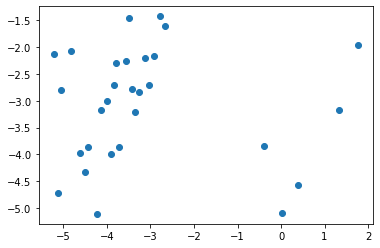

In [19]:
plt.scatter(est,real)

### task 1

In [34]:
stats.spearmanr(est_sub1,real_sub1)

SpearmanrResult(correlation=0.15641500430120533, pvalue=0.5225200563413421)

In [19]:
1 - spatial.distance.cosine(est_sub1,real_sub1)

0.0403516482952857

In [20]:
np.corrcoef(est_sub1,real_sub1)

array([[1.        , 0.02294597],
       [0.02294597, 1.        ]])

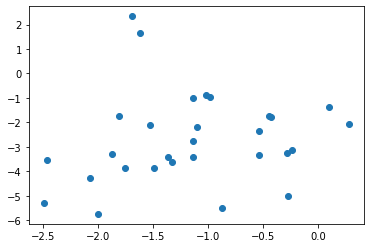

In [22]:
plt.scatter(est_sub1,real_sub1)

### task 2

In [35]:
stats.spearmanr(est_sub2,real_sub2)

SpearmanrResult(correlation=0.5955209384801763, pvalue=0.007139540438419903)

In [24]:
1 - spatial.distance.cosine(est_sub2,real_sub2)

0.6905724290271665

In [25]:
np.corrcoef(est_sub2,real_sub2)

array([[1.        , 0.67145035],
       [0.67145035, 1.        ]])

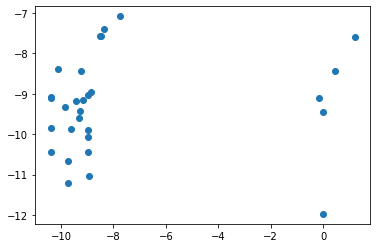

In [23]:
plt.scatter(est_sub2,real_sub2)

### task 3

In [36]:
stats.spearmanr(est_sub3,real_sub3)

SpearmanrResult(correlation=0.12126556513239514, pvalue=0.6209312126812179)

In [28]:
1 - spatial.distance.cosine(est_sub3,real_sub3)

0.9582296238510127

In [29]:
np.corrcoef(est_sub3,real_sub3)

array([[1.        , 0.77240937],
       [0.77240937, 1.        ]])

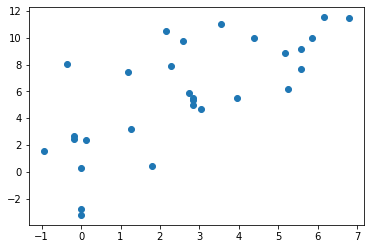

In [24]:
plt.scatter(est_sub3,real_sub3)

# task 4 & 5

In [23]:
stats.spearmanr(est_sub4,real_sub4)

SpearmanrResult(correlation=0.7115971925324748, pvalue=0.00043393026923154885)

In [24]:
stats.spearmanr(est_sub5,real_sub5)

SpearmanrResult(correlation=0.21106094808126408, pvalue=0.3717291478411401)

# Flops of Top5

In [18]:
# layout_idx = [45,0,50,37,49,2] # NYUv2 resnet top-5
# layout_idx = [7,11,10,9,8,0,2] # NYUv2 mobilenet top-5
# layout_idx = [352,958,480,353,360,0,4] # Taskonomy resnet top-5
# layout_idx = [2947,3221,3215,3220,3261,0,4] # Taskonomy mobilenet top-5
layout_idx = [2947]

In [14]:
if model == 'resnet':
    prototxt = 'models/deeplab_resnet34_adashare.prototxt'
    coarse_B = 5
    mapping = {0:[0], 1:[1,2,3], 2:[4,5,6,7], 3:[8,9,10,11,12,13], 4:[14,15,16], 5:[17]}
elif model == 'mobilenet':
    prototxt = 'models/mobilenetv2.prototxt'
#     coarse_B = 9
#     mapping = {0:[0], 1:[1,2], 2:[3,4,5,6], 3:[7,8,9,10,11], 4:[12,13,14,15,16,17], 5:[18,19,20,21,22], 
#            6:[23,24,25,26,27], 7:[28,29,30], 8:[31], 9:[32]} 
#     coarse_B = 6
#     mapping = {0:[0], 1:[1,2,3,4,5,6], 2:[7,8,9,10,11], 3:[12,13,14,15,16,17], 4:[18,19,20,21,22,23,24,25,26,27], 5:[28,29,30,31], 6:[32]}
    coarse_B = 5
    mapping = {0:[0,1,2,3,4,5,6], 1:[7,8,9,10,11,12,13,14,15,16,17], 2:[18,19,20,21,22], 
           3:[23,24,25,26,27,28,29,30], 4:[31], 5:[32]}

In [15]:
if data == 'NYUv2':
    cls_num = {'segment_semantic': 40, 'normal':3, 'depth_zbuffer': 1}
    input_dim = (3,321,321)
elif data == 'Taskonomy':
    cls_num = {'segment_semantic': 17, 'normal': 3, 'depth_zbuffer': 1, 'keypoints2d': 1, 'edge_texture': 1}
    input_dim = (3,224,224)

In [16]:
with torch.cuda.device(0):
    backbone = MTSeqBackbone(prototxt)
    fined_B = len(backbone.basic_blocks)
    feature_dim = backbone(torch.rand((1,)+input_dim)).shape[1]

In [19]:
for idx in layout_idx:
    layout = coarse_to_fined(layout_list[idx], fined_B, mapping)
#     with torch.cuda.device(0):
    with torch.no_grad():
        model = MTSeqModel(prototxt, layout=layout, feature_dim=feature_dim, cls_num=cls_num)
        macs, params = get_model_complexity_info(model, input_dim, as_strings=True,
                                               print_per_layer_stat=True, verbose=False)
        print('Layout idx: '+str(idx))
        print('{:<30}  {:<8}'.format('Computational complexity: ', macs))
        print('='*80)

Construct MTSeqModel from Layout:
[[{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}], [{2}, {0, 1, 3, 4}]]
MTSeqModel(
  261.484 M, 100.000% Params, 13.235 GMac, 100.000% MACs, 
  (backbone): MTSeqBackbone(
    4.448 M, 1.701% Params, 0.638 GMac, 4.820% MACs, 
    (inputNode): InputNode(0.0 M, 0.000% Params, 0.0 GMac, 0.000% MACs, )
    (mtl_blocks): ModuleList(
      4.448 M, 1.701% Params, 0.638

## top-k under flops

In [16]:
K = 5
flops = 171.39 # Taskonomy, resnet
count = 0
for i in range(0,len(layout_order)):
    if count >= K:
        break
    L = coarse_to_fined(layout_list[layout_order[i]], fined_B, mapping)
    with torch.no_grad():
        model = MTSeqModel(prototxt, layout=L, feature_dim=feature_dim, cls_num=cls_num, verbose=False)
        macs, params = get_model_complexity_info(model, input_dim, as_strings=True,
                                               print_per_layer_stat=False, verbose=False)
    if float(macs[:-5]) <= flops:
        print(layout_order[i])
        print(layout_list[layout_order[i]])
        print(layout_list[layout_order[i]].score)
        print(macs)
        print('=' * 100)
        
        count += 1

958
[[{1, 2, 4}, {0, 3}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {2}, {1}], [{0, 3}, {4}, {2}, {1}]]
2.1406691092673733
169.47 GMac
480
[[{1, 2, 3, 4}, {0}], [{1, 2, 3, 4}, {0}], [{0}, {3}, {1, 2, 4}], [{0}, {3}, {2, 4}, {1}], [{0}, {3}, {2, 4}, {1}]]
2.1089931778379
168.75 GMac
360
[[{1, 2, 3, 4}, {0}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {1, 2}], [{0}, {3, 4}, {2}, {1}], [{0}, {3, 4}, {2}, {1}]]
2.045923858933043
169.47 GMac
1037
[[{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{1, 2, 4}, {0, 3}], [{0, 3}, {2, 4}, {1}], [{0, 3}, {2, 4}, {1}]]
1.9554496973706585
151.03 GMac
962
[[{1, 2, 4}, {0, 3}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {1, 2}], [{0, 3}, {4}, {2}, {1}]]
1.8953368092111829
163.73 GMac
